<a href="https://colab.research.google.com/github/oriname/tbd/blob/main/Big_Data_7203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()


import sys, os

sys.path
sys.executable





In [ ]:
!apt-get install openjdk-8-jdk-headless

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark
!pip install pyspark

In [ ]:
import os

os.environ["JAVA_HOME"] =  "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"


import findspark

findspark.init()
findspark.find()


In [ ]:
import pyspark


sc = pyspark.SparkContext(master="local[*]", appName="bigData7203")




In [ ]:
sc.setLogLevel("ERROR")

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local").appName("bigdata").config("spark.ui.port", "4050").getOrCreate()

In [ ]:
spark

# Preprocessing

In [ ]:
import zipfile
import os

# Define the paths to the zip files and the corresponding target folders
zip_paths = ["/content/chat-data.zip", "/content/combined-data.zip", "/content/flamingo-data.zip"]
target_folders = ["/content/chat-data", "/content/combined-data", "/content/flamingo-data"]

# Iterate over the zip paths and target folders
for zip_path, target_folder in zip(zip_paths, target_folders):
    # Extract the contents of the zip file to the target folder
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)

# Print a message when the extraction is complete
print("Extraction complete!")


Extraction complete!


In [ ]:

buy_clicks_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)

In [ ]:
buy_clicks_df.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- txId: integer (nullable = true)
 |-- userSessionId: integer (nullable = true)
 |-- team: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- buyId: integer (nullable = true)
 |-- price: double (nullable = true)



In [ ]:
buy_clicks_df.show(5)

+-------------------+----+-------------+----+------+-----+-----+
|          timestamp|txId|userSessionId|team|userId|buyId|price|
+-------------------+----+-------------+----+------+-----+-----+
|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|
|2016-05-26 15:36:54|6005|         5775|  35|   868|    4| 10.0|
|2016-05-26 15:36:54|6006|         5679|  97|   819|    5| 20.0|
|2016-05-26 16:36:54|6067|         5665|  18|   121|    2|  3.0|
|2016-05-26 17:06:54|6093|         5709|  11|  2222|    5| 20.0|
+-------------------+----+-------------+----+------+-----+-----+
only showing top 5 rows



In [ ]:
buy_clicks_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
timestamp,2947,None,None,2016-05-26 15:36:54,2016-06-16 10:36:54
txId,2947,25443.01085850017,9343.543792592367,6004,39842
userSessionId,2947,22884.75229046488,8669.35362676463,5652,39275
team,2947,70.31896844248388,40.27452540199273,2,178
userId,2947,1187.4591109602986,685.7038088341923,1,2387
buyId,2947,2.530709195792331,1.7799870722907862,0,5
price,2947,7.263997285374957,7.076313004712134,1.0,20.0


# Begin Exploratory Data Analysis

In [ ]:
users_df = spark.read.csv("/content/flamingo-data/users.csv", header=True, inferSchema=True)
team_df = spark.read.csv("/content/flamingo-data/team.csv", header=True, inferSchema=True)
adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)
buyclicks_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)

users_df.show(10)





+-------------------+------+-----------+----------+----------+-------+
|          timestamp|userId|       nick|   twitter|       dob|country|
+-------------------+------+-----------+----------+----------+-------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|     PF|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|1979-11-12|     JO|
+-------------------+------+-----------+----------+----------+-------+
only s

In [ ]:
###### CONVERT DOB TO AGE

from pyspark.sql import functions as f




users_with_age_df = users_df.withColumn("age",   (f.months_between(f.current_date(), f.col('dob')) / 12).cast('int'))

users_with_age_df.show(5)



+-------------------+------+-----------+--------+----------+-------+---+
|          timestamp|userId|       nick| twitter|       dob|country|age|
+-------------------+------+-----------+--------+----------+-------+---+
|2012-06-19 14:53:41|   442|   pcjIOBKW|@SZhyOHv|1994-07-20|     BA| 28|
|2012-06-19 19:29:01|   949|    vAOfUkf|  @nkkNo|1971-04-22|     HU| 52|
|2012-06-20 19:34:59|  1654|     qOOXSQ|  @SwOlw|1970-04-19|     IS| 53|
|2012-06-21 01:18:29|  1586|    px4gW51|@IrCHTnE|1965-11-23|     AM| 57|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc| @VJj0Az|1994-08-23|     CC| 28|
+-------------------+------+-----------+--------+----------+-------+---+
only showing top 5 rows



In [ ]:
# list(users_with_age_df.toPandas()["age"].values)
users_with_age_df.show()

+-------------------+------+-----------+----------+----------+-------+---+
|          timestamp|userId|       nick|   twitter|       dob|country|age|
+-------------------+------+-----------+----------+----------+-------+---+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA| 28|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU| 52|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS| 53|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM| 57|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC| 28|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH| 36|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM| 31|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ| 45|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|     PF| 71|
|2012-06-23 17:40:35|    75|     fNWewX|   @OXqLyv|1979-11-12|     JO| 43|
|2012-06-23 17:57:05|  22

In [ ]:
users_with_age_df.toPandas()[["age"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,2393.0,46.163393,14.070283,24.0,34.0,44.0,57.0,76.0


In [ ]:
from pyspark.sql.functions import udf


age_range = udf(lambda age: '< 20' if age < 20 else 
                       '20-29' if (age >= 20 and age < 30) else
                       '30-39' if (age >= 30 and age < 40) else
                       '40-49' if (age >= 40 and age < 50) else        
                       '50-59' if (age >= 50 and age < 60) else
                       '60-70' if (age >= 60 and age < 70) else
                       '70-79' if (age >= 70 and age < 79) else
                       '80-100' if (age >= 80 and age < 101)  else ""    
                       )

users_with_age_df = users_with_age_df.withColumn('age_group', age_range(users_with_age_df.age))
users_with_age_df.show()

+-------------------+------+-----------+----------+----------+-------+---+---------+
|          timestamp|userId|       nick|   twitter|       dob|country|age|age_group|
+-------------------+------+-----------+----------+----------+-------+---+---------+
|2012-06-19 14:53:41|   442|   pcjIOBKW|  @SZhyOHv|1994-07-20|     BA| 28|    20-29|
|2012-06-19 19:29:01|   949|    vAOfUkf|    @nkkNo|1971-04-22|     HU| 52|    50-59|
|2012-06-20 19:34:59|  1654|     qOOXSQ|    @SwOlw|1970-04-19|     IS| 53|    50-59|
|2012-06-21 01:18:29|  1586|    px4gW51|  @IrCHTnE|1965-11-23|     AM| 57|    50-59|
|2012-06-21 15:35:00|   599|9gkfwRC73Uc|   @VJj0Az|1994-08-23|     CC| 28|    20-29|
|2012-06-22 11:36:19|   952| BRbb3VOTti|   @b4OK6K|1986-09-11|     MH| 36|    30-39|
|2012-06-23 08:11:18|  1056|    fGCIAtI| @IgDsdWdU|1991-11-28|     SM| 31|    30-39|
|2012-06-23 10:54:19|    91|tpDfgi3S0N9|   @LvTHGO|1977-07-03|     BZ| 45|    40-49|
|2012-06-23 14:59:26|   809| LkNRpRW6Ez|@ROrRkXwdh|1951-09-25|   

In [ ]:
data = users_with_age_df.toPandas()
data.loc[data['age']<=19, 'age_group'] = 'teenage'
data.loc[data['age'].between(20,35), 'age_group'] = '20-35'
data.loc[data['age'].between(36,50), 'age_group'] = '36-50'
data.loc[data['age'].between(51,65), 'age_group'] = '51-65'
data.loc[data['age'].between(66,100), 'age_group'] = '66-100'

data



,timestamp,userId,nick,twitter,dob,country,age,age_group
0,2012-06-19 14:53:41,442,pcjIOBKW,@SZhyOHv,1994-07-20,BA,28,20-35
1,2012-06-19 19:29:01,949,vAOfUkf,@nkkNo,1971-04-22,HU,52,51-65
2,2012-06-20 19:34:59,1654,qOOXSQ,@SwOlw,1970-04-19,IS,53,51-65
3,2012-06-21 01:18:29,1586,px4gW51,@IrCHTnE,1965-11-23,AM,57,51-65
4,2012-06-21 15:35:00,599,9gkfwRC73Uc,@VJj0Az,1994-08-23,CC,28,20-35
...,...,...,...,...,...,...,...,...
2388,2016-06-11 05:17:17,2312,CJOHXgqKh,@ZomNVFWoF,1996-10-05,MT,26,20-35
2389,2016-06-14 03:19:04,100,lJexGia,@BYQ14xmNd,1987-05-25,CR,35,20-35
2390,2016-06-14 10:40:22,651,iynipG41EV,@nXTCcg7sV,1987-04-08,CI,36,36-50
2391,2016-06-15 16:33:25,2390,hH9wrFLdTt,@KimUIQF,1991-03-02,TK,32,20-35


In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
import pyspark.sql.functions as f


window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

w = Window.partitionBy('x')

users_with_age_df_grouped = users_with_age_df.groupBy('age_group').count()\
        .select('age_group', f.col('count').alias('age_group_count'))\
        .sort(f.asc("age_group")) 


users_with_age_df_grouped.show()

+---------+---------------+
|age_group|age_group_count|
+---------+---------------+
|    20-29|            310|
|    30-39|            602|
|    40-49|            552|
|    50-59|            431|
|    60-70|            326|
|    70-79|            172|
+---------+---------------+



In [ ]:
team_df = spark.read.csv("/content/flamingo-data/team.csv", header=True, inferSchema=True)
buyclicks_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)


team_buying_df = team_df.alias("teamdf").join(buyclicks_df.alias("buyclicks"),\
                            f.col("teamdf.teamId") == f.col("buyclicks.team"),"inner")

team_buying_df_grouped = team_buying_df.groupBy("teamId").sum("price", "strength")\
         .select('teamId', f.col('sum(price)').alias('total_spending'), f.col('sum(strength)').alias('total_strength'))\
         .orderBy("sum(price)")


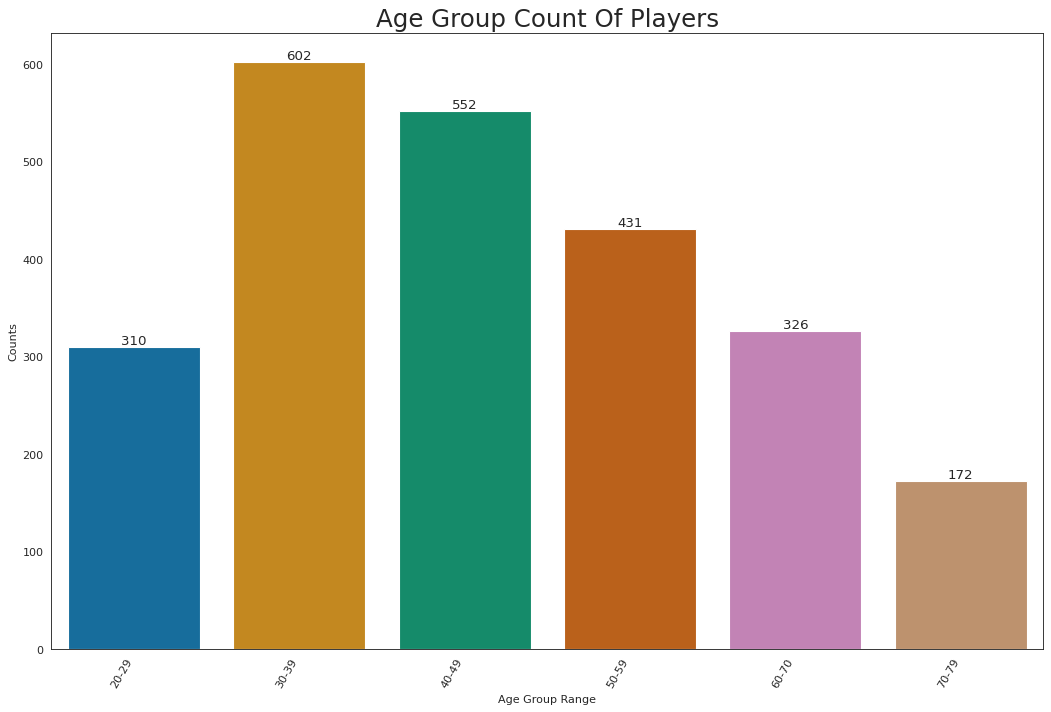

<Figure size 640x480 with 0 Axes>

In [ ]:

# users_with_age_df.toPandas().hist(column = "age", bins = 10)
import matplotlib.pyplot as plt
import seaborn as sns

import random

# Import Data
df_raw = users_with_age_df_grouped



# Prepare Data
df = users_with_age_df_grouped.toPandas()
n = users_with_age_df_grouped["age_group"].size+1


all_colors = list(plt.cm.colors.cnames.keys())
random.seed(100)
c = random.choices(all_colors, k=7)

# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
ax = sns.barplot(x="age_group", y="age_group_count", data=df,

                 palette="colorblind")

for i, val in enumerate(df['age_group_count'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Decoration
plt.gca().set_xticklabels(df['age_group'], rotation=60, horizontalalignment= 'right')
plt.title("Age Group Count Of Players", fontsize=22)
plt.ylabel('Counts')
plt.xlabel('Age Group Range')
plt.show()
# Save the plot
plt.savefig('Age Group Count of Players.png')

plt.show()




In [ ]:
users_with_age_df.groupBy("country").count().orderBy("count").show(6)

+-------+-----+
|country|count|
+-------+-----+
|     UA|    9|
|     SD|    9|
|     EE|    9|
|     MR|    9|
|     CM|    9|
|     AZ|    9|
+-------+-----+
only showing top 6 rows



In [ ]:
!pip install scipy

In [ ]:
# df = team_buying_df_grouped.toPandas() 

df

,age_group,age_group_count
0,20-29,310
1,30-39,602
2,40-49,552
3,50-59,431
4,60-70,326
5,70-79,172


In [ ]:
from matplotlib import patches
from scipy.spatial import ConvexHull
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
sns.set_style("white")

# Step 1: Prepare Data
df = team_buying_df_grouped.toPandas() 

# As many colors as there are unique midwest['category']
categories = np.unique(df['teamId'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Step 2: Draw Scatterplot with unique color for each category
fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')    


# Step 3: Draw Scatterplot

ax = sns.scatterplot(data=df, x="total_spending", y="total_strength", hue="teamId",size="teamId", legend="full")
m, b = np.polyfit(df["total_spending"], df["total_strength"], 1)





# Step 3.1 : Set Legend
# plt.setp(ax.get_legend().get_texts(), fontsize='7') # for legend text
# plt.setp(ax.get_legend().get_title(), fontsize='7') # for legend title

# Step 4: Decorations

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.xlabel("Team Spending")
plt.ylabel("Team Strength")
plt.legend(title='Team Ids', fontsize=7)

plt.title("Scatter Plot of team total spending vs team strength", fontsize=22)

plt.show()   

team_buying_df_grouped.stat.corr("total_spending","total_strength")


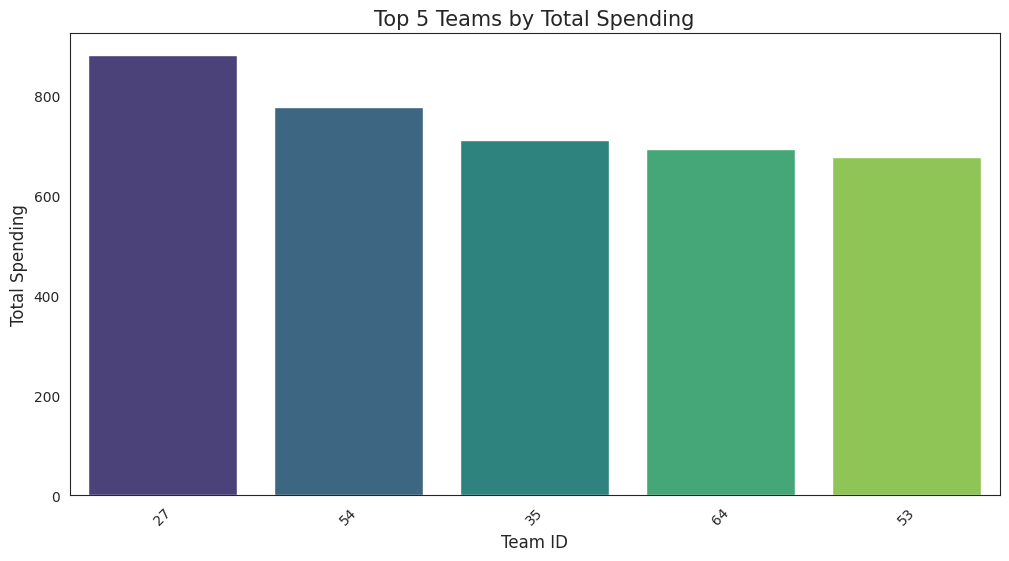

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Assuming df is your dataframe

# Sort the dataframe by 'total_spending' and get the top 5
df_top5 = df.sort_values('total_spending', ascending=False).head(5)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='teamId', y='total_spending', data=df_top5, palette='viridis', order=df_top5['teamId'])

plt.xlabel('Team ID', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.title('Top 5 Teams by Total Spending', fontsize=15)
plt.xticks(rotation=45)

# Save the plot
plt.savefig('top5_teams_spending2.png')

plt.show()



In [ ]:
!pip install pycountry_convert 

In [ ]:
##############  TEAMS SPENDING LOLLIPOP GRAPH


# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
 

# Step 1: Prepare Data
df = team_buying_df_grouped.toPandas() 
 
# Reorder it based on values:
ordered_df = df.sort_values(by='total_spending')
my_range=range(1,len(df.index)+1)

 # Create a color if the group is "B"
my_color=np.where(ordered_df['total_spending']==ordered_df['total_spending'].max(), 'orange', 'skyblue')
my_size=np.where(ordered_df['total_spending']==ordered_df['total_spending'].max() , 70, 30)


fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')    

# The horizontal plot is made using the hline() function
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['total_spending'], color=my_color, alpha=0.4)

plt.scatter(ordered_df['total_spending'], my_range, color=my_color, s=my_size, alpha=1)

# Add title and axis names
plt.yticks(my_range, ordered_df['teamId'])
plt.title("Team With Highest Spendings", loc='left')
plt.xlabel('Team Spendings')
plt.ylabel('Team Id')

# show the graph
plt.show()

In [ ]:
############# TEAM SPENDING WITH AGE GROUP
team_user_buying_df = team_buying_df.alias("team_buying_df").join(users_df.alias("users_df"),\
                           f.col("team_buying_df.userId") == f.col("users_df.userId"),"inner")

In [ ]:
import pycountry_convert as pc
from pyspark.sql.types import StringType



def country_to_continent(country_name):
  try:
    country_continent_code = pc.country_alpha2_to_continent_code(country_name)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name
  except:
    return "None"





udf_country_to_continent = f.udf(country_to_continent , StringType())
team_user_buying_df = team_user_buying_df.withColumn("continent", udf_country_to_continent(f.col("country") ))



team_user_buying_df.show()

+------+-----------+-------------------+-------------------+---------------+------------+-------------------+----+-------------+----+------+-----+-----+-------------------+------+----------+----------+----------+-------+-------------+
|teamId|       name|   teamCreationTime|        teamEndTime|       strength|currentLevel|          timestamp|txId|userSessionId|team|userId|buyId|price|          timestamp|userId|      nick|   twitter|       dob|country|    continent|
+------+-----------+-------------------+-------------------+---------------+------------+-------------------+----+-------------+----+------+-----+-----+-------------------+------+----------+----------+----------+-------+-------------+
|     9|  pDG2bAh8T|2016-06-13 17:39:55|9999-12-31 23:59:59| 0.952175553216|           1|2016-05-26 15:36:54|6004|         5820|   9|  1300|    2|  3.0|2013-12-01 09:30:47|  1300|   2hh0NNM|  @RY1URF2|1998-05-06|     GR|       Europe|
|    35|b3PqpjmZ6TT|2016-06-14 02:08:07|9999-12-31 23:59:59|

In [ ]:
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col


window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

team_user_buying_df_stat = team_user_buying_df.groupby("continent").agg(f.sum('price').alias('spending_count'),
                                        f.mean('price').alias('price_avg'),
                                        f.min('price').alias('price_min'),
                                        f.max('price').alias('price_max')).\
   withColumn('total',sum(f.col('spending_count')).over(window)).\
   withColumn('Percent',f.col('spending_count')*100/f.col('total'))

team_user_buying_df_stat.show()

+-------------+--------------+------------------+---------+---------+-------+------------------+
|    continent|spending_count|         price_avg|price_min|price_max|  total|           Percent|
+-------------+--------------+------------------+---------+---------+-------+------------------+
|         None|         684.0|              11.4|      1.0|     20.0|16576.0| 4.126447876447877|
|       Europe|        2974.0| 7.548223350253807|      1.0|     20.0|16576.0|17.941602316602317|
|       Africa|        3889.0| 7.282771535580524|      1.0|     20.0|16576.0|23.461631274131275|
|North America|        2726.0| 7.593314763231198|      1.0|     20.0|16576.0|16.445463320463322|
|   Antarctica|          51.0|             2.125|      1.0|     10.0|16576.0|0.3076737451737452|
|South America|        1416.0|10.114285714285714|      1.0|     20.0|16576.0| 8.542471042471043|
|      Oceania|        1410.0| 5.802469135802469|      1.0|     20.0|16576.0|  8.50627413127413|
|         Asia|        3426.0|

In [ ]:
print (team_user_buying_df_stat.columns)

['continent', 'spending_count', 'price_avg', 'price_min', 'price_max', 'total', 'Percent']


In [ ]:
!pip install squarify 


In [ ]:
!pip install pywaffle

In [ ]:
import matplotlib.pyplot as plt
import squarify    # pip install squarify (algorithm for treemap)
import pandas as pd


# Get dataframe continent & Percent columns as list
labels = list(team_user_buying_df_stat.toPandas()["continent"])
sizes =  list(team_user_buying_df_stat.toPandas()["Percent"])

perc = [f'{i/team_user_buying_df_stat.toPandas()["Percent"].sum()*100:5.2f}%' for i in team_user_buying_df_stat.toPandas()["Percent"]]
lbl = [f'{el[0]} = {el[1]}' for el in zip(team_user_buying_df_stat.toPandas()["continent"], perc)]

# select colors
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]
# plot it
plt.figure(figsize=(16,8), dpi= 80)
squarify.plot(sizes=sizes, label=lbl, color=colors ,alpha=.8 )
plt.title('Treemap of high total purchase continents')
plt.axis('off')
plt.show()

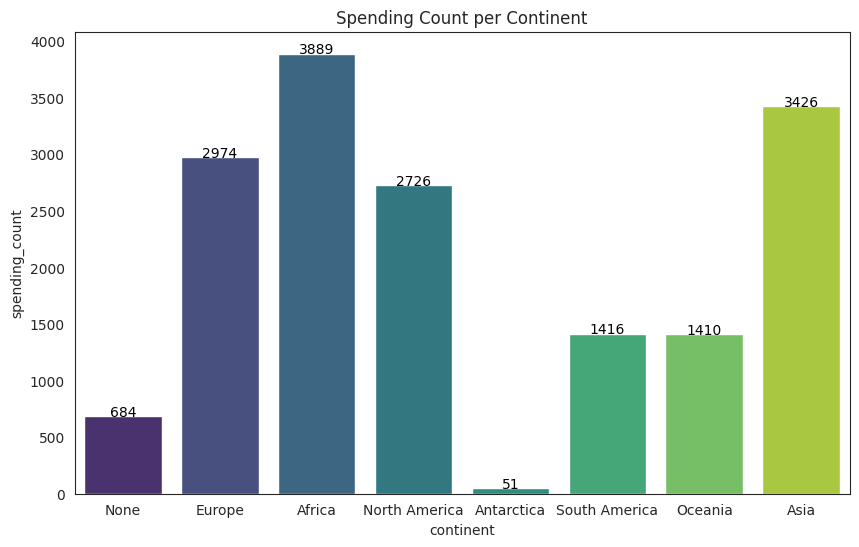

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = team_user_buying_df_stat.toPandas()

# Bar plot for spending_count per continent
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='continent', y='spending_count', data=df, palette='viridis')

# Add the spending count on top of each bar
for i, row in df.iterrows():
    barplot.text(i, row.spending_count, int(row.spending_count), color='black', ha="center")

plt.title('Spending Count per Continent')

# Save the figure
plt.savefig('spending_count_per_continent2.png', dpi=300, bbox_inches='tight')

plt.show()


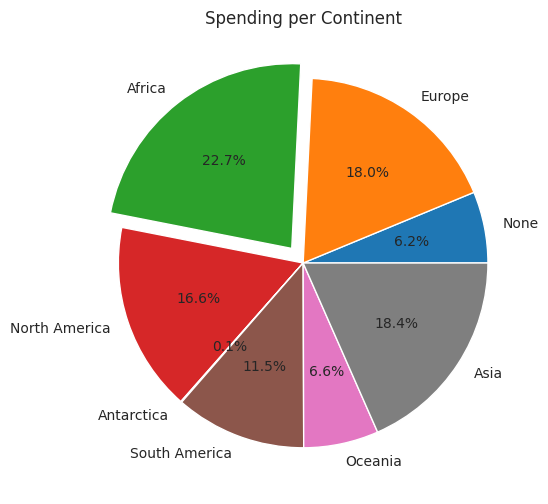

In [ ]:
import matplotlib.pyplot as plt

# Assuming df is your dataframe
df = team_user_buying_df_stat.toPandas()

# Calculate total spending
df['total_spending'] = df['spending_count'] * df['price_avg']

# Identify the section with the highest percentage
explode = (df['total_spending'] == df['total_spending'].max()).astype(int) * 0.1

# Plotting
plt.figure(figsize=(10, 6))
plt.pie(df['total_spending'], labels=df['continent'], autopct='%1.1f%%', explode=explode)
plt.title('Spending per Continent')

# Save the figure
plt.savefig('spending_per_continent2.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
team_user_buying_df_stat.show()

+-------------+--------------+------------------+---------+---------+-------+------------------+
|    continent|spending_count|         price_avg|price_min|price_max|  total|           Percent|
+-------------+--------------+------------------+---------+---------+-------+------------------+
|         None|         684.0|              11.4|      1.0|     20.0|16576.0| 4.126447876447877|
|       Europe|        2974.0| 7.548223350253807|      1.0|     20.0|16576.0|17.941602316602317|
|       Africa|        3889.0| 7.282771535580524|      1.0|     20.0|16576.0|23.461631274131275|
|North America|        2726.0| 7.593314763231198|      1.0|     20.0|16576.0|16.445463320463322|
|   Antarctica|          51.0|             2.125|      1.0|     10.0|16576.0|0.3076737451737452|
|South America|        1416.0|10.114285714285714|      1.0|     20.0|16576.0| 8.542471042471043|
|      Oceania|        1410.0| 5.802469135802469|      1.0|     20.0|16576.0|  8.50627413127413|
|         Asia|        3426.0|

In [ ]:
from re import X

######### PLOT PIE GRAPH OF HIGH SPENDING CONTINENTS
import matplotlib.pyplot as plt
import seaborn as sns


labels = list(team_user_buying_df_stat.toPandas()["continent"])
sizes =  list(team_user_buying_df_stat.toPandas()["Percent"])


colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red', "brown"]
# explode = tuple( if X == 0 else x=0 for x in range(len(labels)) ) 

max = 0
for i in sizes:
  if max< i:
    max = i
  

explode = list(0 for _ in sizes)

explode[sizes.index(max)]  = 0.1

# 0, 0.1, 0, 0,0,0
# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes,explode = explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

In [ ]:
!pip install pywaffle

In [ ]:
from pywaffle import Waffle
import matplotlib.pyplot as plt


labels = list(team_user_buying_df_stat.toPandas()["continent"])
sizes =  list(team_user_buying_df_stat.toPandas()["Percent"])

df = team_user_buying_df_stat.toPandas()
n_categories = df.shape[0]
colors = [plt.cm.inferno_r(i/float(n_categories)) for i in range(n_categories)]

# Draw Plot and Decorate
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '111': {
            'values': df['Percent'],
            'labels': ["{0} ({1})".format(n[0], n[1]) for n in df[['continent', 'Percent']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12},
            'title': {'label': 'Continents with most in-game purchases', 'loc': 'center', 'fontsize':18}
        },
    },
    rows=7,
    colors=colors,
    figsize=(16, 9)
)

TypeError: ignored

In [ ]:
################### TEAM SPENDING AND TEAM RANK CORR



#team_user_buying_df.show()
team_user_buying_df.stat.corr("price","currentLevel")






nan

In [ ]:
#################### AD CLICK CHECK 
###### CHECK WHICH ITEM SELLS WELL

from pyspark.sql.functions import rank,sum,col
# import matplotlib.pyplot as plt

adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)
buy_clicks_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)

item_purchases_stat_df = buy_clicks_df.groupby("buyId").agg(sum(f.col("price")).alias("total_price")).orderBy("buyId").toPandas()



item_purchase_stat_df = list(item_purchases_stat_df["buyId"])
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k') 
item_purchases_stat_df.plot.bar(width=1.2)
plt.xticks(rotation=0)
plt.title("Highest Sold Products", loc='left')
plt.xlabel('Product Id')
plt.ylabel('Total Spending')
# buy_clicks_df.show()



In [ ]:
adclicks_df.head(1)

[Row(timestamp='2016-05-26 15:13:22', txId=5974, userSessionId=5809, teamId=27, userId=611, adId=2, adCategory='electronics')]

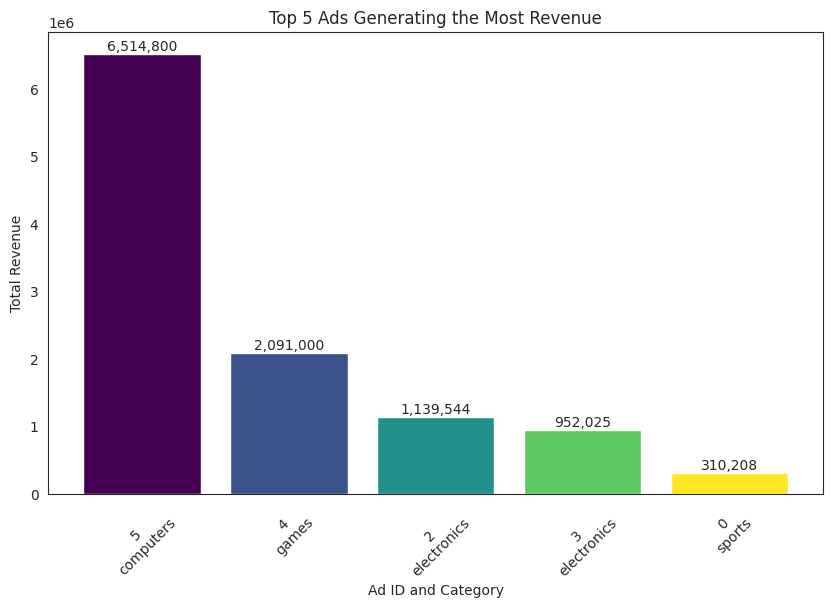

In [ ]:
from pyspark.sql.functions import desc

# Assuming adclicks_df has a column 'adCategory' which specifies the category of each 'buyId'
adclicks_df = adclicks_df.withColumnRenamed("adId", "buyId")

# Join the two DataFrames on 'buyId' to get the 'adCategory' for each 'buyId' in buy_clicks_df
df = buy_clicks_df.join(adclicks_df, "buyId")

# Group by 'buyId' and 'adCategory', sum the prices, and order by the sum
df_grouped = df.groupBy("buyId", "adCategory").sum("price").orderBy(desc("sum(price)"))

# Convert to pandas for plotting
df_pandas = df_grouped.toPandas()

# Plot only the top five ads
df_pandas = df_pandas.head(5)

# Create a new column that combines 'buyId' and 'adCategory' for the x-axis labels
df_pandas['buyId_adCategory'] = df_pandas['buyId'].astype(str) + '\n' + df_pandas['adCategory']

import matplotlib.pyplot as plt
import numpy as np

# Plot the data
plt.figure(figsize=(10, 6))

# Create a color palette with as many colors as there are bars
colors = plt.cm.viridis(np.linspace(0, 1, len(df_pandas)))

# Plot the bars with different colors
bars = plt.bar(df_pandas['buyId_adCategory'], df_pandas['sum(price)'], color=colors)
plt.title('Top 5 Ads Generating the Most Revenue')
plt.xlabel('Ad ID and Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)

# Define the offset for moving the figures up
offset = 1000

# Add the figures on the bars with an offset
for bar in bars:
    yval = bar.get_height()
    # Format the number with commas and add it to the bar, centered horizontally and moved up by the offset
    plt.text(bar.get_x() + bar.get_width() / 2, yval + offset, '{:,.0f}'.format(yval), va='bottom', ha='center')

# Save the figure
plt.savefig('top5_ads_revenue.png', dpi=300, bbox_inches='tight')

plt.show()







+-------------------+----+-------------+------+------+----+-----------+
|          timestamp|txId|userSessionId|teamId|userId|adId| adCategory|
+-------------------+----+-------------+------+------+----+-----------+
|2016-05-26 15:13:22|5974|         5809|    27|   611|   2|electronics|
|2016-05-26 15:17:24|5976|         5705|    18|  1874|  21|     movies|
|2016-05-26 15:22:52|5978|         5791|    53|  2139|  25|  computers|
|2016-05-26 15:22:57|5973|         5756|    63|   212|  10|    fashion|
|2016-05-26 15:22:58|5980|         5920|     9|  1027|  20|   clothing|
|2016-05-26 15:27:19|5977|         5954|    77|   595|   4|      games|
|2016-05-26 15:28:51|5981|         5674|    54|   770|   6|     movies|
|2016-05-26 15:35:25|5975|         5919|    59|  2133|   3|electronics|
|2016-05-26 15:35:37|5979|         5945|    75|   253|   3|electronics|
|2016-05-26 15:36:38|5972|         5914|    78|  1821|  12|  computers|
|2016-05-26 15:38:42|6000|         5955|    64|  2009|  17|     

<Axes: title={'center': 'Time Series of Adclick per Day'}, xlabel='Days', ylabel='Ads clicked'>

<Figure size 2000x2000 with 0 Axes>

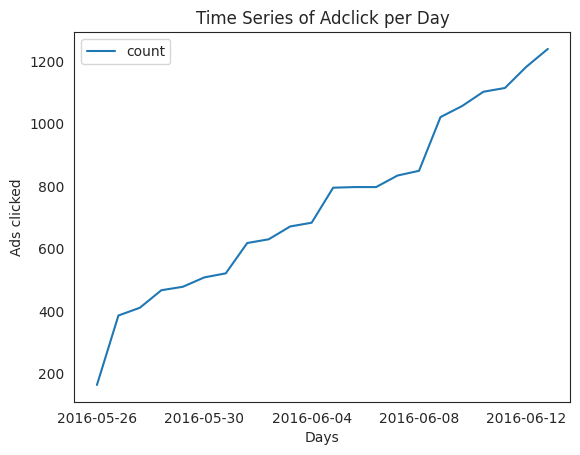

In [ ]:
adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)


adclicks_df.show()
#######  FORMAT THE TIMESTAMP COLUMN IN DF AND THEN GROUP BY THE FORMATTED DF 
# To groupby newly created month column which holds  date in yyyy-MM-dd form. 
# count the occurance of each date. as each new date represents a click on ad.
plt.figure(figsize=(20,20))
# adclicks_df.groupby("adCategory").count().orderBy("count").show()
adclicks_df.withColumn("tstamp",f.date_format(adclicks_df.timestamp,'yyyy-MM-dd') )\
.withColumn("hstamp",f.date_format(adclicks_df.timestamp,'hh:mm:ss') )\
.withColumn("month",f.date_format(adclicks_df.timestamp,'yyyy-MM-dd') )\
.select("month")\
.groupBy("month")\
.count()\
.orderBy("count")\
.toPandas()\
.plot.line(x="month", y="count", xlabel="Days", ylabel="Ads clicked", title="Time Series of Adclick per Day")


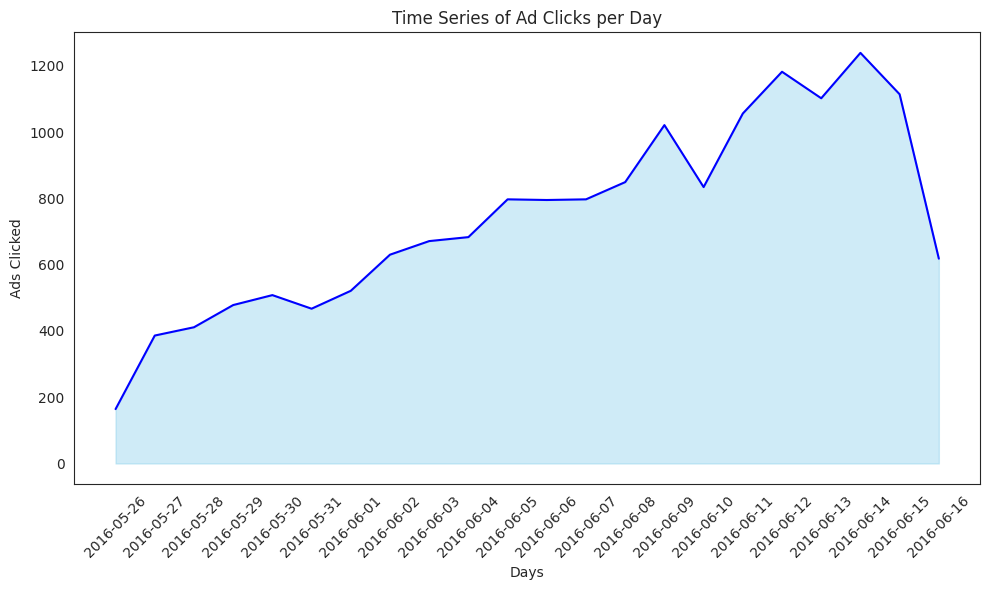

In [ ]:
import matplotlib.pyplot as plt
import pyspark.sql.functions as f

adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)

# Format the timestamp column in the DataFrame and group by the formatted column
grouped_df = adclicks_df.withColumn("formatted_timestamp", f.date_format(adclicks_df.timestamp, 'yyyy-MM-dd')) \
    .groupBy("formatted_timestamp") \
    .count() \
    .orderBy("formatted_timestamp")

# Convert the result to a Pandas DataFrame for plotting
pandas_df = grouped_df.toPandas()

# Plot the time series using an area plot with markers
plt.figure(figsize=(10, 6))
plt.fill_between(pandas_df["formatted_timestamp"], pandas_df["count"], color='skyblue', alpha=0.4)
plt.plot(pandas_df["formatted_timestamp"], pandas_df["count"], color='b')

plt.xlabel("Days")
plt.ylabel("Ads Clicked")
plt.title("Time Series of Ad Clicks per Day")

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an image
plt.savefig('adclicks_time_series.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
print(adclicks_df.columns)

['timestamp', 'txId', 'userSessionId', 'teamId', 'userId', 'adId', 'adCategory']


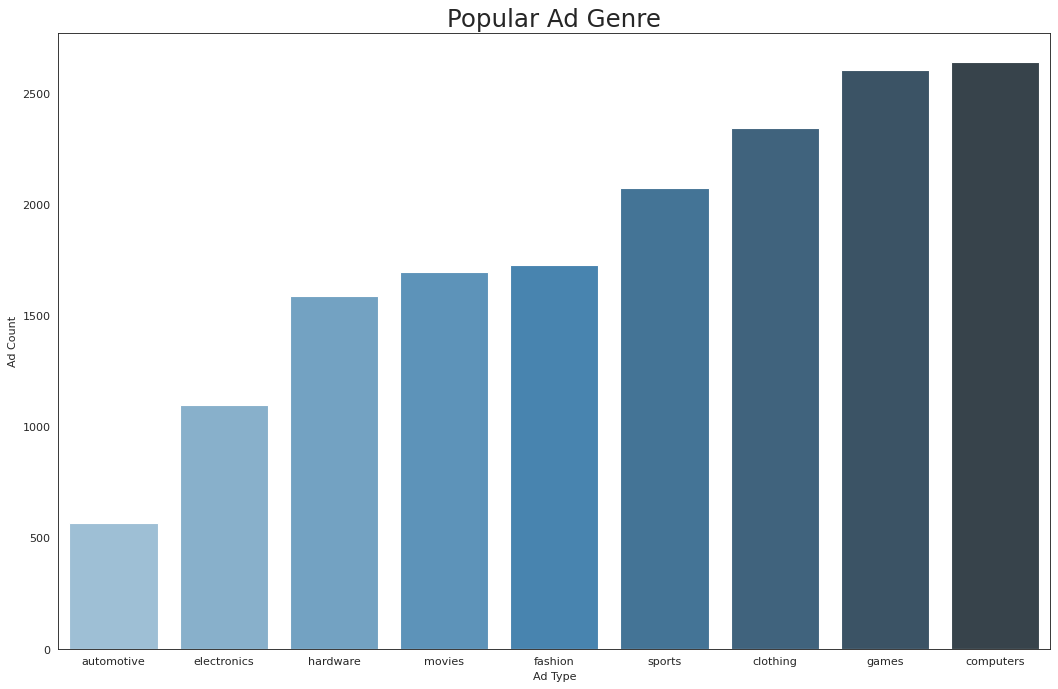

In [ ]:

import seaborn as sns
import pyspark.sql.functions as f
adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)



adclicks_df_stat = adclicks_df.groupBy("adCategory").agg(f.count("adCategory").alias("count")).orderBy("count").toPandas()
                                            


# users_with_age_df.toPandas().hist(column = "age", bins = 10)
import matplotlib.pyplot as plt
import seaborn as sns

import random




# Plot Bars
plt.figure(figsize=(16,10), dpi= 80)
ax = sns.barplot(x="adCategory", y="count", data=adclicks_df_stat,

                 palette="Blues_d")


plt.title("Popular Ad Genre", fontsize=22)
plt.ylabel('Ad Count')
plt.xlabel('Ad Type')
plt.show()







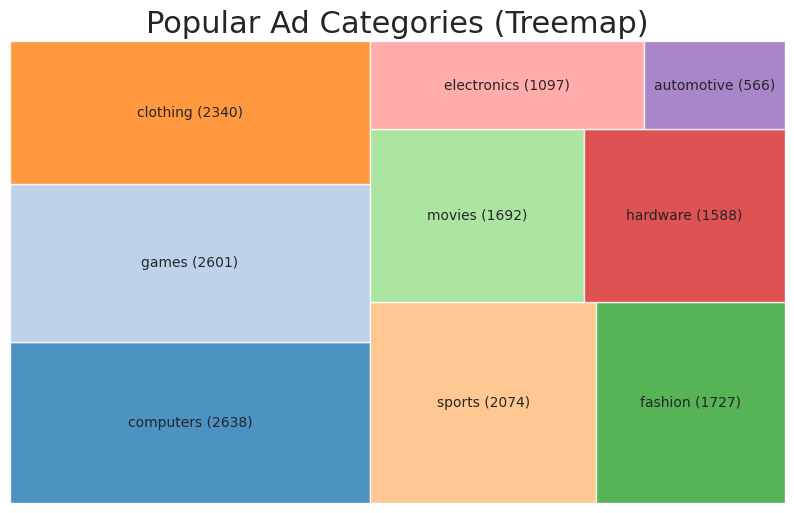

In [ ]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns
import pyspark.sql.functions as f

# Group adclicks_df by "adCategory" and count the occurrences
adclicks_df_stat = adclicks_df.groupBy("adCategory").agg(f.count("adCategory").alias("count")).orderBy("count").toPandas()

# Sort the data by count in descending order
adclicks_df_stat = adclicks_df_stat.sort_values(by='count', ascending=False)

# Choose a color palette from seaborn or matplotlib
colors = sns.color_palette("tab20", n_colors=len(adclicks_df_stat))

# Plot the treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=adclicks_df_stat['count'], label=adclicks_df_stat.apply(lambda x: f"{x['adCategory']} ({x['count']})", axis=1),
              color=colors, alpha=0.8)
plt.axis('off')

plt.title("Popular Ad Categories (Treemap)", fontsize=22)

# Save the plot as an image
plt.savefig('popular_ad_categories_treemap2.png', dpi=300, bbox_inches='tight')

plt.show()







In [ ]:

################# GET DEVICE TOTAL + PERCENTAGE + INDIVIDUAL PLATFORM

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

user_session_df = spark.read.csv("/content/flamingo-data/user-session.csv", header=True, inferSchema=True)
platform_usage_stats_df = user_session_df.groupBy("platformType").agg(f.mean("teamLevel").alias("average_rank"), 
                                            f.count("platformType").alias("total_platform_count"))\
                                            .orderBy("average_rank")\
                                            .withColumn('total',sum(f.col('total_platform_count')).over(window))\
                                            .withColumn('Percent',f.col('total_platform_count')*100/f.col('total'))\
                                            .orderBy(f.col("Percent").desc())



# team_user_buying_df_stat = team_user_buying_df.groupby("continent").agg(f.sum('price').alias('spending_count'),
#                                         f.mean('price').alias('price_avg'),
#                                         f.min('price').alias('price_min'),
#                                         f.max('price').alias('price_max')).\
#    withColumn('total',sum(f.col('spending_count')).over(window)).\
#    withColumn('Percent',f.col('spending_count')*100/f.col('total'))
# platform_usage_stats_df = platform_usage_stats_df.count().withColumn("total_platform_count", f.col("count"))
platform_usage_stats_df.show()

+------------+-----------------+--------------------+-----+------------------+
|platformType|     average_rank|total_platform_count|total|           Percent|
+------------+-----------------+--------------------+-----+------------------+
|      iphone|4.349509550851833|                3874| 9250| 41.88108108108108|
|     android|4.388515577275504|                3274| 9250|35.394594594594594|
|     windows|4.364516129032258|                1240| 9250|13.405405405405405|
|       linux|4.182539682539683|                 504| 9250| 5.448648648648649|
|         mac|4.379888268156424|                 358| 9250|3.8702702702702703|
+------------+-----------------+--------------------+-----+------------------+



In [ ]:
#################### DONUT PLOT
platform_usage_stats_df




import pandas as pd
import re


user_session_df = spark.read.csv("/content/flamingo-data/user-session.csv", header=True, inferSchema=True)
# platform_usage_stats_df = user_session_df.groupBy("platformType").agg(f.mean("teamLevel").alias("average_rank"), 
#                                             f.count("platformType").alias("total_platform_count")).orderBy("average_rank")


# xlabels = list(platform_usage_stats_df.toPandas()["platformType"])
# # platform_usage_stats_df.toPandas().plot.bar()

# labels = list(platform_usage_stats_df.toPandas()["platformType"])
# sizes =  list(platform_usage_stats_df.toPandas()["total_platform_count"])

data = platform_usage_stats_df.toPandas()


import matplotlib.pyplot as plt


fig = plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

# create donut plots
startingRadius = 0.7 + (0.3* (len(data)-1))
for index, row in data.iterrows():
    scenario = row["platformType"]
    percentage = row["Percent"]
    textLabel = scenario.capitalize() + ' ' + str(round(percentage,2)) + " %"
    print(startingRadius)
    #percentage = int(re.search(r'\d+', percentage).group())
    remainingPie = 100 - percentage

    donut_sizes = [remainingPie, percentage]

    plt.text(0.01, startingRadius - 0.197, textLabel, horizontalalignment='center', verticalalignment='center')
    plt.pie(donut_sizes, radius=startingRadius, startangle=90, colors=['#d5f6da', '#5cdb6f'],
            wedgeprops={"edgecolor": "white", 'linewidth': 1})

    startingRadius-=0.3



# equal ensures pie chart is drawn as a circle (equal aspect ratio)
plt.axis('equal')

# create circle and place onto pie chart
circle = plt.Circle(xy=(0, 0), radius=0.35, facecolor='white')
plt.gca().add_artist(circle)
plt.show()

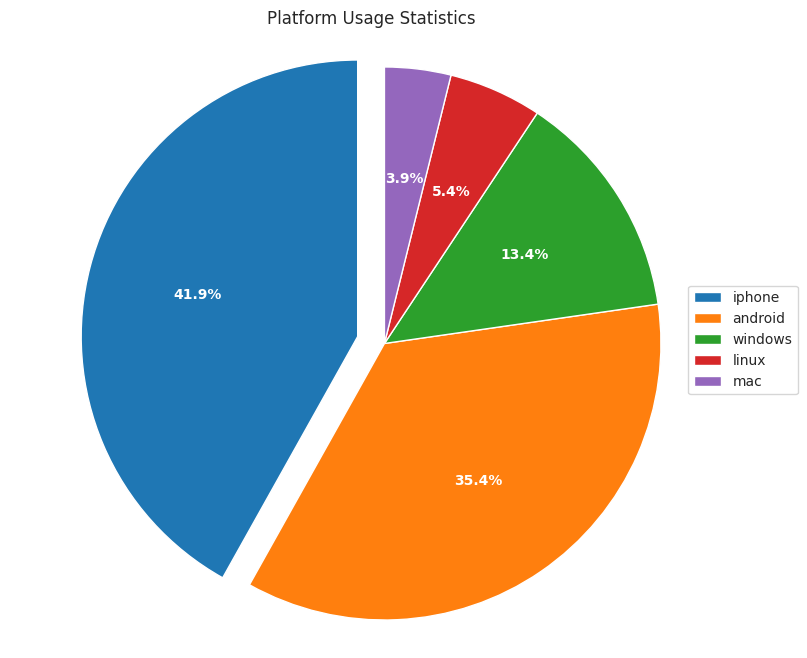

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

platform_usage_stats_df = user_session_df.groupBy("platformType").count().toPandas()

# Sort the data by count in descending order
platform_usage_stats_df.sort_values(by="count", ascending=False, inplace=True)

# Use a color palette for the pie chart
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2"]

# Generate the explode parameter
explode = [0.1 if i == 0 else 0 for i in range(len(platform_usage_stats_df))]

# Plot the pie chart with improved colors, aesthetics, explode, and labels
plt.figure(figsize=(8, 8))
plt.pie(platform_usage_stats_df["count"], labels=platform_usage_stats_df["platformType"], autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 1}, explode=explode, textprops={'color': 'white', 'weight': 'bold'})

plt.title("Platform Usage Statistics")

plt.axis('equal')  # Ensure a perfect circle shape

# Add platform type names outside the pie chart
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left')

# Save the image to a file
plt.savefig('platform_usage_statistics2.png', dpi=300, bbox_inches='tight')

plt.show()




In [ ]:
############## GET DEVICE PIE CHART


import matplotlib.pyplot as plt
import seaborn as sns




user_session_df = spark.read.csv("/content/flamingo-data/user-session.csv", header=True, inferSchema=True)
platform_usage_stats_df = user_session_df.groupBy("platformType").agg(f.mean("teamLevel").alias("average_rank"), 
                                            f.count("platformType").alias("total_platform_count")).orderBy("average_rank")


xlabels = list(platform_usage_stats_df.toPandas()["platformType"])
# platform_usage_stats_df.toPandas().plot.bar()

labels = list(platform_usage_stats_df.toPandas()["platformType"])
sizes =  list(platform_usage_stats_df.toPandas()["total_platform_count"])


colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red', "brown"]
# explode = tuple( if X == 0 else x=0 for x in range(len(labels)) ) 

max = 0
for i in sizes:
  if max< i:
    max = i
  

explode = list(0 for _ in sizes)

explode[sizes.index(max)]  = 0.1

# 0, 0.1, 0, 0,0,0
# Plot
plt.figure(figsize=(10,8))
plt.pie(sizes,explode = explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)


# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color="white")
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.axis('equal')




plt.show()





In [ ]:
######################### CHECKING ON AVERAGE A PLAYER JOINS HOW MANY TEAMS
team_assigments = spark.read.csv("/content/flamingo-data/team-assignments.csv", header=True, inferSchema=True)


team_assigment_stats_df = team_assigments.groupBy("userId").agg(f.count("userId").alias("count")).select("count","userId").orderBy("count")
x = team_assigment_stats_df.select("count").toPandas()

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x, palette="Set3")
ax.set(xlabel='Average number of times person joins a team', ylabel='count', 
       title = "Plot showing statistics of players joining teams")



ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x, color = 'black')
ax.set(xlabel='Count of time person joins a team', ylabel='count', title = "Plot showing statistics of players joining teams")





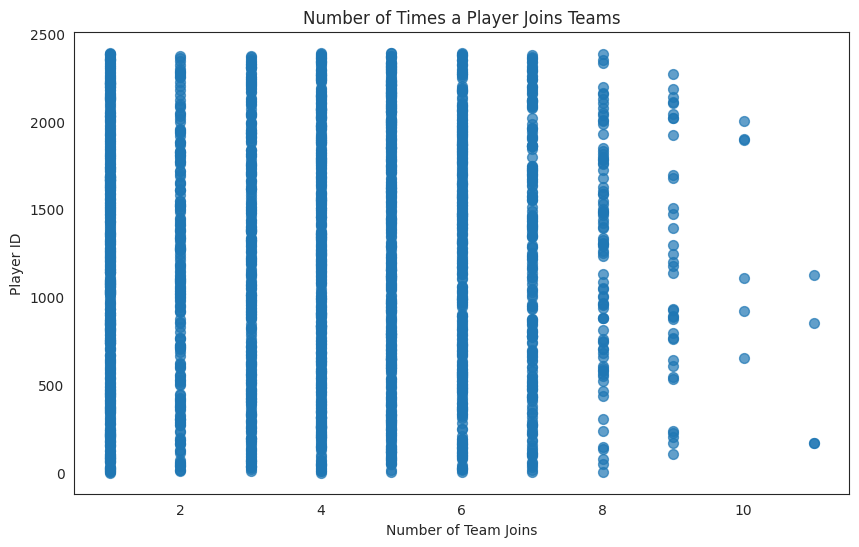

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

team_assigment_stats_df = team_assigments.groupBy("userId").agg(f.count("userId").alias("count")).select("count", "userId")

# Convert Spark DataFrame columns to Pandas Series
counts = team_assigment_stats_df.select("count").toPandas()["count"]
user_ids = team_assigment_stats_df.select("userId").toPandas()["userId"]

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x=counts, y=user_ids, s=50, alpha=0.7)
plt.xlabel("Number of Team Joins")
plt.ylabel("Player ID")
plt.title("Number of Times a Player Joins Teams")
plt.show()


In [ ]:
######################## CHECKING HIGHER RANK TEAMS PLAY WHICH EVENTS
######################### GAME CLICKS IS PLATFORM DEPENDANT

import pyspark.sql.functions as f

game_clicks_df = spark.read.csv("/content/flamingo-data/game-clicks.csv", header=True, inferSchema=True)
user_session_df = spark.read.csv("/content/flamingo-data/user-session.csv", header=True, inferSchema=True)

game_clicks_user_session_df = game_clicks_df.alias("game_clicks_df").join(
    user_session_df.alias("user_session_df"),
    f.col("game_clicks_df.userid") == f.col("user_session_df.userId"),
    "inner"
)

game_clicks_user_session_pf_df = game_clicks_user_session_df.groupby("platformType")\
    .agg(
        f.sum(f.when(f.col("isHit") == 1, 1).otherwise(0)).alias("platform_hit_count"),
        f.count("isHit").alias("total_hits")
    )\
    .withColumn("percentage", f.col("platform_hit_count") / f.col("total_hits"))\
    .orderBy("platform_hit_count")

ylabels = list(game_clicks_user_session_pf_df.toPandas()["platformType"])

game_clicks_user_session_pf_df.toPandas().plot(
    kind='barh',
    figsize=(12, 8),
    logx=True
).set_yticklabels(ylabels)

game_clicks_user_session_pf_df.show()





In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20, 8))

# Load the example car crash dataset
crashes = game_clicks_user_session_pf_df.toPandas()

print(crashes.head())

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total_hits", y="platformType", data=crashes,
            label="Total clicks", color="b")


for bar, percentage in zip(ax.patches, crashes['percentage'].values[::-1]):
    ax.annotate( str(round(float(percentage),5) * 100 ) + " %" ,xy=(bar.get_width(), bar.get_y()+bar.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

# for bar, percentage in zip(ax.patches, crashes['percentage'].values[::-1]):
#     ax.text(0.8, bar.get_y()+bar.get_height()/2, percentage, color = 'white', ha = 'left', va = 'center')

# for i, val in enumerate(crashes['percentage'].values):
#     ax.text(val, i, str(round(float(val),4) * 100 ) + " %", horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':12})

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="platform_hit_count", y="platformType", data=crashes,
            label="Hit counts", color="b")


# Add a legend and informative axis label

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="Devices with total clicks vs hit counts")
sns.despine(left=True, bottom=True)

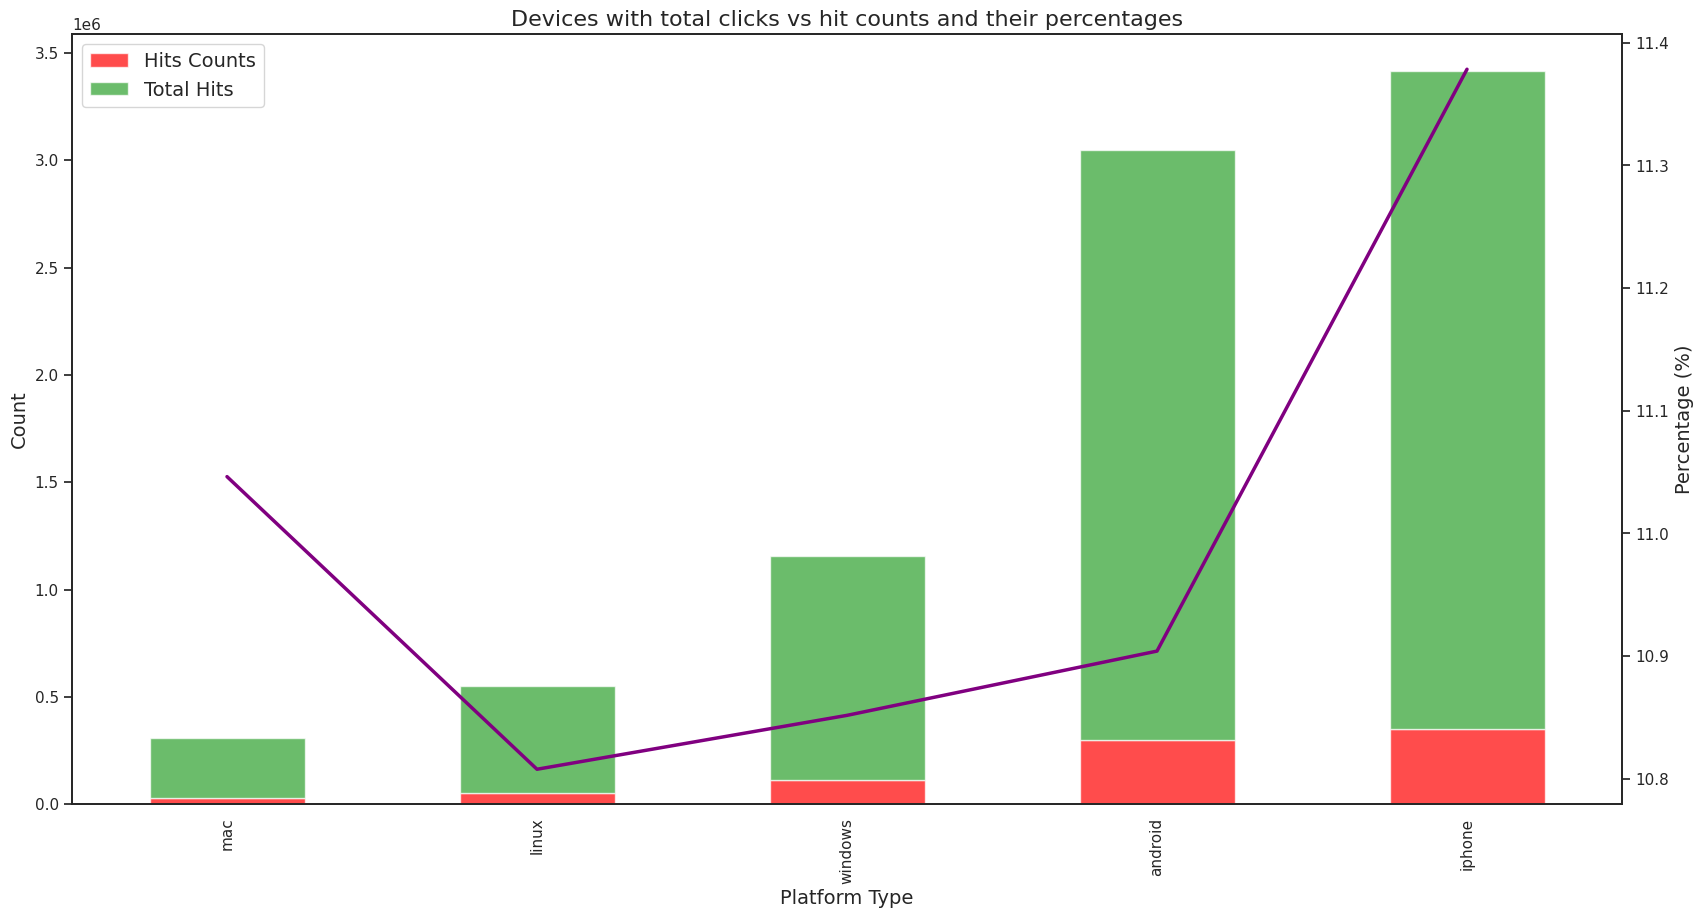

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(style="white")

# Load the example game clicks dataset
crashes = game_clicks_user_session_pf_df.toPandas()

# Convert percentage to a whole number
crashes['percentage'] = crashes['percentage'] * 100

# create a figure and some subplots
fig, ax1 = plt.subplots(figsize=(20, 10))

# stacked bar chart
colors = ['red', '#2ca02c']  # Shades of blue and green
crashes.set_index('platformType')[['platform_hit_count', 'total_hits']].plot(kind='bar', stacked=True, ax=ax1, color=colors, alpha=0.7)  # Added alpha
ax1.set_ylabel('Count', fontsize=14)
ax1.set_xlabel('Platform Type', fontsize=14)
ax1.legend(["Hits Counts", "Total Hits"], fontsize=14)

# remove grid lines
ax1.grid(False)

# instantiate a second y-axis sharing x-axis with ax1
ax2 = ax1.twinx()

# line plot for percentages
sns.lineplot(x='platformType', y='percentage', data=crashes, sort=False, color='#800080', ax=ax2, linewidth=2.5)  # Vibrant purple
ax2.set_ylabel('Percentage (%)', fontsize=14)

# remove grid lines
ax2.grid(False)

# set the title
plt.title('Devices with total clicks vs hit counts and their percentages', fontsize=16)

# save the plot
plt.savefig('hit_ratio.png')

# show the plot
plt.show()


In [ ]:
crashes.head(2)

,platformType,platform_hit_count,total_hits,percentage
0,mac,30582,276852,11.046335
1,linux,53910,498808,10.807766


In [ ]:
############# CORR
from pyspark.sql import functions as f

team_df = spark.read.csv("/content/flamingo-data/team.csv", header=True, inferSchema=True)
buyclicks_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)


team_buying_df = team_df.alias("teamdf").join(buyclicks_df.alias("buyclicks"),\
                            f.col("teamdf.teamId") == f.col("buyclicks.team"),"inner")



########## HISTOGRAM OF SPENDING COUNT HOW MUCH SPENDING IS DISTRIBUTED && CORRELATION

# team_buying_df.groupBy("teamId").sum("price", "strength").orderBy("sum(price)").toPandas().hist(column = "sum(price)")


team_buying_df_grouped = team_buying_df.groupBy("teamId").sum("price", "strength")\
         .select('teamId', f.col('sum(price)').alias('total_spending'), f.col('sum(strength)').alias('total_strength'))\
         .orderBy("sum(price)")

team_buying_df.stat.corr("price","strength")
# team_buying_df_grouped.show()

-0.06938790495270436

In [ ]:
################ CLUSTERING ANALYSIS

# Utility functions for Spark Cluster Analysis Hands-On
#
#
from itertools import cycle, islice
from math import sqrt
from numpy import array
from pandas.plotting import parallel_coordinates
from pyspark.ml.clustering import KMeans as KM
from pyspark.mllib.linalg import DenseVector
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def computeCost(featuresAndPrediction, model):
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    arrayCollection   = featuresAndPrediction.rdd.map(array)

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)


def elbow(elbowset, clusters):
	wsseList = []	
	for k in clusters:
		print("Training for cluster size {} ".format(k))
		kmeans = KM(k = k, seed = 1)
		model = kmeans.fit(elbowset)
		transformed = model.transform(elbowset)
		featuresAndPrediction = transformed.select("features", "prediction")

		W = computeCost(featuresAndPrediction, model)
		print("......................WSSE = {} ".format(W))

		wsseList.append(W)
	return wsseList

def elbow_plot(wsseList, clusters):
	wsseDF = pd.DataFrame({'WSSE' : wsseList, 'k' : clusters })
	wsseDF.plot(y='WSSE', x='k', figsize=(15,10), grid=True, marker='o')

def pd_centers(featuresUsed, centers):
	colNames = list(featuresUsed)
	colNames.append('prediction')

	# Zip with a column called 'prediction' (index)
	Z = [np.append(A, index) for index, A in enumerate(centers)]

	# Convert to pandas for plotting
	P = pd.DataFrame(Z, columns=colNames)
	P['prediction'] = P['prediction'].astype(int)
	return P

def parallel_plot(data, P):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(P)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
	parallel_coordinates(data, 'prediction', color = my_colors, marker='o')



In [ ]:
df = spark.read.csv("/content/combined-data/combined-data.csv", header=True, inferSchema=True)

df

DataFrame[userId: int, userSessionId: int, teamLevel: int, platformType: string, count_gameclicks: int, count_hits: int, count_buyId: string, avg_price: string]

In [ ]:
df.count()
df.na.drop().count()





4619

In [ ]:
print(df.columns)

['userId', 'userSessionId', 'teamLevel', 'platformType', 'count_gameclicks', 'count_hits', 'count_buyId', 'avg_price']


In [ ]:
################ K-MEANS CLUSTERING
ad_click_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)
buy_click_df = spark.read.csv("/content/flamingo-data/buy-clicks.csv", header=True, inferSchema=True)
game_click_df = spark.read.csv("/content/flamingo-data/game-clicks.csv", header=True, inferSchema=True)
level_events_df = spark.read.csv("/content/flamingo-data/level-events.csv", header=True, inferSchema=True)
team_assignments_df = spark.read.csv("/content/flamingo-data/team-assignments.csv", header=True, inferSchema=True)
team_df = spark.read.csv("/content/flamingo-data/team.csv", header=True, inferSchema=True)
users_df = spark.read.csv("/content/flamingo-data/users.csv", header=True, inferSchema=True)
users_session_df = spark.read.csv("/content/flamingo-data/user-session.csv", header=True, inferSchema=True)












In [ ]:
################# JOIN ALL TABLES

whole_dataset_df = team_assignments_df.alias("team_assignment_df").join(users_df.alias("users_df"),\
                           f.col("team_assignment_df.userId") == f.col("users_df.userId"),"inner")\
                           .join(team_df.alias("team_df"), f.col("team_df.teamId") == f.col("team"))\
                           .join(users_session_df.alias("users_session_df"), f.col("users_session_df.userId") == f.col("users_df.userId"))\
                           .join(game_click_df.alias("game_click_df"), f.col("game_click_df.userId") == f.col("users_df.userId"))\
                           .join(ad_click_df.alias("ad_click_df"), f.col("ad_click_df.userId") == f.col("users_df.userId"))\
                           .join(buy_click_df.alias("buy_click_df"), f.col("buy_click_df.userId") == f.col("users_df.userId"))\
                           .select("team_assignment_df.timestamp", "team_assignment_df.timestamp", 
                                   "users_df.userId", "users_df.nick", "users_df.twitter","users_df.country","users_df.dob",
                                   "team_df.teamId","team_df.teamCreationTime", "team_df.teamEndTime", "team_df.strength","team_df.currentLevel",
                                   "users_session_df.timestamp","users_session_df.timestamp", "users_session_df.sessionType","users_session_df.teamLevel","users_session_df.platformType",
                                   "game_click_df.timestamp", "game_click_df.isHit",
                                   "ad_click_df.adId", "ad_click_df.adCategory",
                                   "buy_click_df.txId","buy_click_df.price")\
                          

In [ ]:
whole_dataset_df = whole_dataset_df.select('strength',
 'teamLevel',
 'isHit',
 'price').distinct()

# print(whole_dataset_df.count())


# whole_dataset_df.show()


In [ ]:
############# CLASSIFICATION AND CLUSTERING ANALYSIS
import pyspark.sql.functions as f
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col


window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)


combined_data_df = spark.read.csv("/content/combined-data/combined-data.csv", header=True, inferSchema=True)

combined_data_df_na_removed = combined_data_df.na.drop()
# combined_data_df_hitter = combined_data_df.withColumn('Percent',f.col('count_hits')*100/f.col('count_gameclicks'))\
#                           .withColumn("hitter", f.when(f.col("Percent") > 10, 1).otherwise(0))\
#                           .withColumn('total',sum(f.col('avg_price')).over(window))\
#                           .withColumn("spender", f.when(f.col("avg_price") > 5,1).otherwise(0))

                          
combined_data_df_hitter = combined_data_df\
                          .withColumn('total',sum(f.col('avg_price')).over(window))\
                          .withColumn("spender", f.when(f.col("avg_price") > 5,1).otherwise(0))





grouped_userId_combined_data_df  = combined_data_df_hitter.groupby("userId")\
                                  .agg(f.sum("count_gameclicks").alias('count_gameclicks_total'), 
                                       f.sum("count_hits").alias("count_hits_total"), 
                                       f.sum("avg_price").alias("avg_price_total"))\
                                  .withColumn('Percent',f.col('count_hits_total')*100/f.col('count_gameclicks_total'))\
                                  .withColumn("hitter", f.when(f.col("Percent") > 10, 1).otherwise(0))\
                                  


combined_grouped_df = combined_data_df_hitter.alias("combined_data_df_hitter").join(grouped_userId_combined_data_df.alias("grouped_userId_combined_data_df"),\
                           f.col("combined_data_df_hitter.userId") == f.col("grouped_userId_combined_data_df.userId"),"inner")\

                          
combined_grouped_df.show()


# team_user_buying_df_stat = team_user_buying_df.groupby("continent").agg(f.sum('price').alias('spending_count'),
#                                         f.mean('price').alias('price_avg'),
#                                         f.min('price').alias('price_min'),
#                                         f.max('price').alias('price_max')).\
#    withColumn('total',sum(f.col('spending_count')).over(window)).\

# combined_data_df_hitter = combined_data_df_hitter.groupby("userId")\
#                           .agg(f.sum('avg_price').alias('total'))\
#                           .withColumn("spender", f.when(f.col("total") > 5,1).otherwise(0))
# max_value = combined_data_df_hitter.agg({"Percent": "max"}).collect()[0][0]
# print(max_value)
# team_user_buying_df.groupby("continent").agg(f.sum('price').alias('spending_count'),
#                                         f.mean('price').alias('price_avg'),
#                                         f.min('price').alias('price_min'),
#                                         f.max('price').alias('price_max')).\
#    withColumn('total',sum(f.col('spending_count')).over(window)).\
#    withColumn('Percent',f.col('spending_count')*100/f.col('total'))

# combined_data_df.show()
# combined_data





+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|10179.410000000002|      0|   812|                   669|              74|           null|11.061285500747385|     1|
|  1658|         5649|        1|      iphone|              31|         5|       NULL|     NULL|10179.410000000002|      0|  1658|                   403|

In [ ]:

##### INDEX THE PLATFORMTYPE CATEGORICAL COLUMN

from pyspark.ml.feature import StringIndexer

# Create an indexer
indexer = StringIndexer(inputCol='platformType', outputCol='platformType_indexed')

# Indexer identifies categories in the data
indexer_model = indexer.fit(combined_grouped_df)

# Indexer creates a new column with numeric index values
combined_grouped_df_indexed = indexer_model.transform(combined_grouped_df)
combined_grouped_df_indexed.show()



+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|10179.410000000002|      0|   812|                   669|              74|           null|11.061285500747385|     1|                 1.0|
|  1658|         5649|        1|      iphone|              31|      

In [ ]:
########### FILL NA IN AVG PRICE WITH 0 


combined_grouped_df_indexed = combined_grouped_df_indexed.fillna({'avg_price_total':'0'})

combined_grouped_df_indexed.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|10179.410000000002|      0|   812|                   669|              74|            0.0|11.061285500747385|     1|                 1.0|
|  1658|         5649|        1|      iphone|              31|      

In [ ]:
############## FEATURE VECTORIZATION



from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
featuresUsed = ['Percent',
 'teamLevel',
"count_gameclicks_total",
"count_hits_total",
"platformType_indexed"
 ]



assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(combined_grouped_df_indexed)

# assembled.show()

# assembled  = assembled.select(featuresUsed)
# Split into training and test sets in a 80:20 ratio
combined_grouped_data_train, combined_grouped_data_test = assembled.randomSplit([0.8, 0.2], seed=17)


combined_grouped_data_train.show()


+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|            features|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+
|     0|        24943|        2|      iphone|             353|        35|       NULL|     NULL|10179.410000000002|      0|     0|                  1240|             124|            0.0|              10.0|     0|                 0.0|[10.0,

In [ ]:


# scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
# scalerModel = scaler.fit(assembled)
# scaledData = scalerModel.transform(assembled)



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='features', k=i)
    KMeans_fit=KMeans_algo.fit(combined_grouped_data_train)
    output=KMeans_fit.transform(combined_grouped_data_train)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.8831256973063182
Silhouette Score: 0.77434223969529
Silhouette Score: 0.7153065610619618
Silhouette Score: 0.7259475589964668
Silhouette Score: 0.6937848684769289
Silhouette Score: 0.6970200425109816
Silhouette Score: 0.6813643677955108
Silhouette Score: 0.7052811242441227


Text(0, 0.5, 'cost')

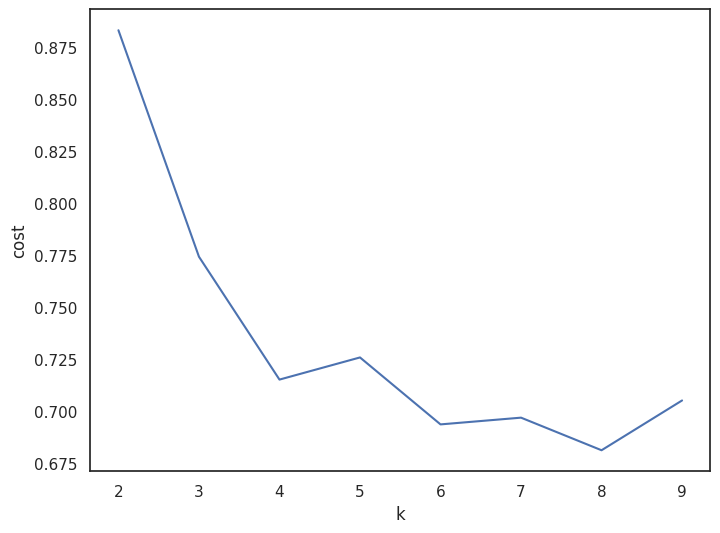

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
print(clusters_output.columns)


['userId', 'userSessionId', 'teamLevel', 'platformType', 'count_gameclicks', 'count_hits', 'count_buyId', 'avg_price', 'total', 'spender', 'userId', 'count_gameclicks_total', 'count_hits_total', 'avg_price_total', 'Percent', 'hitter', 'platformType_indexed', 'features', 'prediction']


In [ ]:
final_clustering=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(combined_grouped_data_test)
clusters_output=KMeans_fit.transform(combined_grouped_data_test)
clusters_output.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|            features|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+----------+
|     0|        23473|        1|      iphone|             237|        28|       NULL|     NULL|10179.410000000002|      0|     0|                  1240|             124|            0.0|              10.0| 

In [ ]:
from logging import Handler
####### PLOT K MEANS
import numpy as np 
import matplotlib.pyplot as plt

df = clusters_output.toPandas()
label = df.prediction.tolist()

u_labels = np.unique(label)



filtereddf = df[df['prediction'] == 1]



##################### ATTEMPT 1 AT PLOTTING
# https://rsandstroem.github.io/sparkkmeans.html

# threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
# threedee.scatter(df.avg_price_total, df.count_hits_total, df.teamLevel  , c=df.prediction)
# threedee.set_xlabel('teamLevel')
# threedee.set_ylabel('count_hits_total')
# threedee.set_zlabel('avg_price_total')

# print(u_labels)
# plt.legend(labels = u_labels, bbox_to_anchor=(1.05, 1), loc=2, )
# plt.show()



###################### ATTEMPT 2 




plt.rcParams["figure.figsize"]=(14,8)
plt.rcParams['legend.fontsize'] = 10
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df.avg_price_total, df.count_hits_total, df.teamLevel  , c=df.prediction, s =150,cmap='rainbow')


scatter = ax.scatter(df.avg_price_total, df.count_hits_total, df.teamLevel, c=df.prediction, s =150,cmap='rainbow')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

ax.legend(loc = 'upper left')

ax.set_xlabel('Price Total',fontsize=20,labelpad=10)
ax.set_ylabel('Total Hit Counts', fontsize=20, rotation=150,labelpad=10)
ax.set_zlabel('Team Level', fontsize=20, rotation=60,labelpad=15)








Text(0.5, 0, 'Team Level')

<Figure size 1400x800 with 0 Axes>

In [ ]:
from logging import Handler
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert to pandas DataFrame
df = clusters_output.toPandas()
label = df.prediction.tolist()

# Unique labels
u_labels = np.unique(label)

# Set the figure size and legend font size
plt.rcParams["figure.figsize"]=(14,8)
plt.rcParams['legend.fontsize'] = 10

# Create a new figure
fig = plt.figure()

# Add a 3D subplot
ax = Axes3D(fig)

# Create a scatter plot
scatter = ax.scatter(df.avg_price_total, df.count_hits_total, df.teamLevel, c=df.prediction, s=150, cmap='rainbow')

# Create a legend
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left", title="Classes")
ax.add_artist(legend1)

# Set the labels
ax.set_xlabel('Price Total', fontsize=20, labelpad=10)
ax.set_ylabel('Total Hit Counts', fontsize=20, rotation=150, labelpad=10)
ax.set_zlabel('Team Level', fontsize=20, rotation=60, labelpad=15)

# Display the plot
plt.show()


<Figure size 1400x800 with 0 Axes>

In [ ]:
print(df[['avg_price_total', 'count_hits_total', 'teamLevel', 'prediction']].isna().sum())


avg_price_total     0
count_hits_total    0
teamLevel           0
prediction          0
dtype: int64


In [ ]:
clusters_output.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+----------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|            features|prediction|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+--------------------+----------+
|     0|        23473|        1|      iphone|             237|        28|       NULL|     NULL|10179.410000000002|      0|     0|                  1240|             124|            0.0|              10.0| 

In [ ]:
combined_grouped_df_indexed.show()

+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|             total|spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|           Percent|hitter|platformType_indexed|
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+------------------+------+--------------------+
|   812|         5648|        1|     android|              69|         8|       NULL|     NULL|10179.410000000002|      0|   812|                   669|              74|            0.0|11.061285500747385|     1|                 1.0|
|  1658|         5649|        1|      iphone|              31|      

Training for cluster size 2 
......................WSSE = 9897.832947236197 
Training for cluster size 3 
......................WSSE = 9052.35131149152 
Training for cluster size 4 
......................WSSE = 7804.294332262038 
Training for cluster size 5 
......................WSSE = 7402.3832302379515 
Training for cluster size 6 
......................WSSE = 7048.319723977783 
Training for cluster size 7 
......................WSSE = 7011.454831986224 
Training for cluster size 8 
......................WSSE = 6648.859149339848 
Training for cluster size 9 
......................WSSE = 6363.240529222316 
Training for cluster size 10 
......................WSSE = 5828.245776956924 
Training for cluster size 11 
......................WSSE = 5822.26276530395 
Training for cluster size 12 
......................WSSE = 5596.8897051554895 
Training for cluster size 13 
......................WSSE = 5466.591940879645 
Training for cluster size 14 
......................WSSE = 5379.90736097

,platformType_indexed,teamLevel,hitter,spender,count_gameclicks_total,avg_price_total,count_hits_total,prediction
0,-0.159078,-0.036365,0.560036,-0.372151,-0.217321,-0.160085,-0.179910,0
1,0.147503,-0.453602,0.287198,-0.137452,2.530351,-0.054809,2.514082,1
2,2.360239,0.004245,-0.201248,-0.292081,-0.246001,-0.399195,-0.261021,2
3,-0.751559,0.301983,0.390343,2.561660,-0.209781,1.790676,-0.104333,3
4,-0.195034,0.118900,-1.785211,-0.358450,-0.328588,-0.454844,-0.479037,4


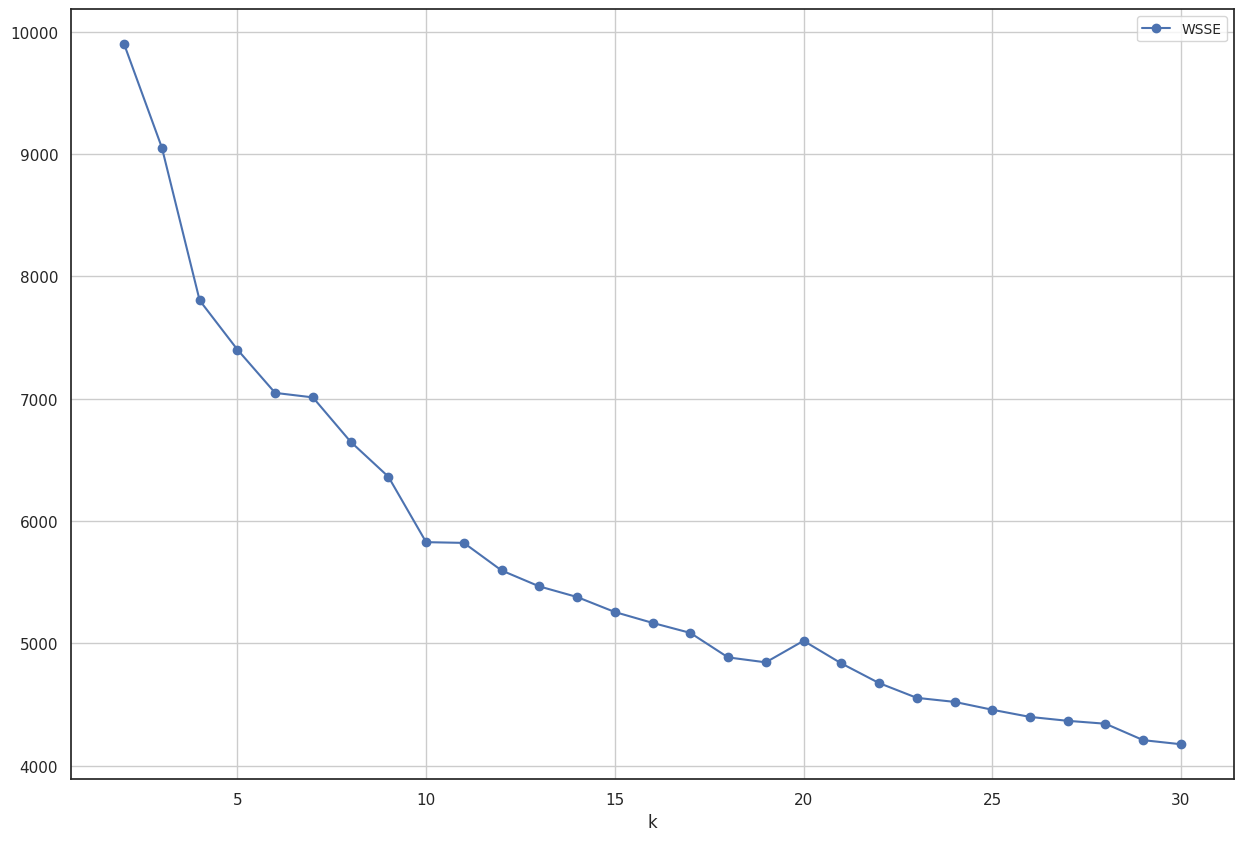

In [ ]:
#################### KMEANS 
featuresUsed = ["platformType_indexed","teamLevel","hitter","spender", "count_gameclicks_total","avg_price_total","count_hits_total"]

# featuresUsed = ['count_gameclicks', 'count_hits' ]
from pyspark.ml.feature import VectorAssembler


assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled_feature = assembler.transform(combined_grouped_df_indexed)


# SCALE THE DATA TO STANDARDIZE DIFFERENT UNITS
scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled_feature)
scaledData = scalerModel.transform(assembled_feature)



# assembled_feature.show()

elbowset = scaledData.select("features","platformType_indexed","count_gameclicks_total","avg_price_total","count_hits_total","teamLevel")
clusters = range(2,31)

wsseList = elbow(elbowset, clusters)


# PLOT ELBOW METHOD
elbow_plot(wsseList, clusters)



# SELECT FEATURE COLUMN
scaledDataFeat = scaledData.select("features","teamLevel", "platformType_indexed","count_gameclicks_total","avg_price_total","count_hits_total","spender","hitter")
scaledDataFeat.persist()


### TRAIN KMEANS MODEL WITH !2 CLusters
kmeans = KMeans(k=5, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

## GET CENTERIODS
centers = model.clusterCenters()
centers


P = pd_centers(featuresUsed, centers)

P.head()













In [ ]:
transformed.show()
centers

+--------------------+---------+--------------------+----------------------+---------------+----------------+-------+------+----------+
|            features|teamLevel|platformType_indexed|count_gameclicks_total|avg_price_total|count_hits_total|spender|hitter|prediction|
+--------------------+---------+--------------------+----------------------+---------------+----------------+-------+------+----------+
|[0.05614147219518...|        1|                 1.0|                   669|            0.0|              74|      0|     1|         0|
|[-0.8902726156499...|        1|                 0.0|                   403|           37.5|              58|      0|     1|         0|
|[-0.8902726156499...|        1|                 0.0|                   289|            0.0|              25|      0|     0|         4|
|[0.05614147219518...|        1|                 1.0|                   371|           13.0|              41|      0|     1|         0|
|[0.05614147219518...|        1|                

[array([-0.15907806, -0.03636503,  0.56003647, -0.37215053, -0.21732124,
        -0.1600847 , -0.17990985]),
 array([ 0.14750323, -0.45360234,  0.28719822, -0.13745186,  2.53035053,
        -0.0548085 ,  2.51408176]),
 array([ 2.3602386 ,  0.00424472, -0.20124819, -0.29208106, -0.24600105,
        -0.39919541, -0.26102093]),
 array([-0.75155886,  0.30198308,  0.3903432 ,  2.56166   , -0.20978065,
         1.79067607, -0.10433334]),
 array([-0.1950345 ,  0.11889969, -1.78521144, -0.35844995, -0.32858808,
        -0.45484407, -0.47903675])]

In [ ]:
parallel_plot(P[P['hitter'] < -0.5], P)

In [ ]:
from logging import Handler
####### PLOT K MEANS
import numpy as np 
import matplotlib.pyplot as plt


df = transformed.toPandas()

label = df.prediction.tolist()

u_labels = np.unique(label)



filtereddf = df[df['prediction'] == 1]



##################### ATTEMPT 1 AT PLOTTING
# https://rsandstroem.github.io/sparkkmeans.html

# threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
# threedee.scatter(df.avg_price_total, df.count_hits_total, df.teamLevel  , c=df.prediction)
# threedee.set_xlabel('teamLevel')
# threedee.set_ylabel('count_hits_total')
# threedee.set_zlabel('avg_price_total')

# print(u_labels)
# plt.legend(labels = u_labels, bbox_to_anchor=(1.05, 1), loc=2, )
# plt.show()



###################### ATTEMPT 2 
# https://stackoverflow.com/questions/69887186/legends-not-appearing-in-3d-plot



plt.rcParams["figure.figsize"]=(14,8)
plt.rcParams['legend.fontsize'] = 10
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df.avg_price_total, df.count_hits_total, df.platformType_indexed  , c=df.prediction, s =150,cmap='rainbow')


scatter = ax.scatter(df.avg_price_total, df.count_hits_total, df.platformType_indexed, c=df.prediction, s =150,cmap='rainbow')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

ax.legend(loc = 'upper left')

ax.set_xlabel('Price Total',fontsize=20,labelpad=10)
ax.set_ylabel('Total Hit Counts', fontsize=20, rotation=150,labelpad=10)
ax.set_zlabel('Team Level', fontsize=20, rotation=60,labelpad=15)









Text(0.5, 0, 'Team Level')

<Figure size 1400x800 with 0 Axes>

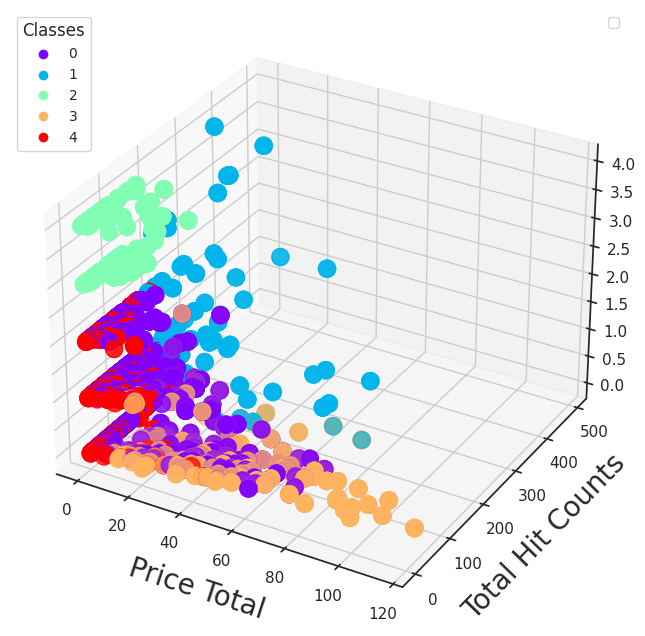

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

df = transformed.toPandas()
label = df.prediction.tolist()
u_labels = np.unique(label)
filtereddf = df[df['prediction'] == 1]

fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df.avg_price_total, df.count_hits_total, df.platformType_indexed,
                     c=df.prediction, s=150, cmap='rainbow')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
ax.legend(loc='upper right')

ax.set_xlabel('Price Total', fontsize=20, labelpad=10)
ax.set_ylabel('Total Hit Counts', fontsize=20, rotation=150, labelpad=10)
ax.set_zlabel('Team Level', fontsize=20, rotation=60, labelpad=15)

plt.show()


In [ ]:
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
featuresUsed = ["avg_price_total",
 'teamLevel',
"platformType_indexed"
 ]



assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(combined_grouped_df_indexed)


# assembled  = assembled.select(featuresUsed)
# Split into training and test sets in a 80:20 ratio
combined_grouped_data_train, combined_grouped_data_test = assembled.randomSplit([0.8, 0.2], seed=17)



# Check the resulting column
combined_grouped_data_train.show(5, truncate=False)




+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+-----------------+------+--------------------+-------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|total             |spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|Percent          |hitter|platformType_indexed|features     |
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+-----------------+------+--------------------+-------------+
|0     |24943        |2        |iphone      |353             |35        |NULL       |NULL     |10179.410000000002|0      |0     |1240                  |124             |0.0            |10.0             |0     |0.0                 |[0.0,2.0,0.0]|
|0     |28377   

In [ ]:
################################## DECISION TREE FOR Hitter

from pyspark.ml.classification import DecisionTreeClassifier




# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier(labelCol='hitter')
tree_model = tree.fit(combined_grouped_data_train)



# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(combined_grouped_data_test)
prediction.select("prediction","rawPrediction","probability", "hitter").show(5, False)







+----------+--------------+----------------------------------------+------+
|prediction|rawPrediction |probability                             |hitter|
+----------+--------------+----------------------------------------+------+
|1.0       |[601.0,1285.0]|[0.31866383881230115,0.6813361611876988]|0     |
|1.0       |[156.0,1218.0]|[0.11353711790393013,0.8864628820960698]|1     |
|1.0       |[601.0,1285.0]|[0.31866383881230115,0.6813361611876988]|0     |
|1.0       |[156.0,1218.0]|[0.11353711790393013,0.8864628820960698]|1     |
|1.0       |[156.0,1218.0]|[0.11353711790393013,0.8864628820960698]|1     |
+----------+--------------+----------------------------------------+------+
only showing top 5 rows



In [ ]:
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tree_model.toDebugString





def parse_debug_string_lines(lines):
    
    block = []
    while lines:


        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block


def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break

    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}

    

    return json



import json

dict_tree_json = debug_str_to_json(tree_model.toDebugString)

print(json.dumps(dict_tree_json,indent = 1 ))








{
 "name": "Root",
 "children": [
  {
   "name": "feature 0 <= 8.165",
   "children": [
    {
     "name": "feature 0 <= 4.165",
     "children": [
      {
       "name": "feature 0 <= 2.165",
       "children": [
        {
         "name": "feature 0 <= 1.625",
         "children": [
          {
           "name": "Predict: 1.0"
          }
         ]
        },
        {
         "name": "feature 0 > 1.625",
         "children": [
          {
           "name": "feature 2 in {0.0,3.0}",
           "children": [
            {
             "name": "Predict: 0.0"
            }
           ]
          },
          {
           "name": "feature 2 not in {0.0,3.0}",
           "children": [
            {
             "name": "Predict: 1.0"
            }
           ]
          }
         ]
        }
       ]
      },
      {
       "name": "feature 0 > 2.165",
       "children": [
        {
         "name": "feature 2 in {0.0}",
         "children": [
          {
           "name": "Predict:

In [ ]:
f_type_to_flist_dict = prediction.schema['features'].metadata["ml_attr"]["attrs"]

f_index_to_name_dict = {}

for f_type, f_list in f_type_to_flist_dict.items():


    for f in f_list: 
      f_index = f['idx']
      f_name = f['name']
      f_index_to_name_dict[f_index] = f_name


print(f_index_to_name_dict)



{0: 'avg_price_total', 1: 'teamLevel', 2: 'platformType_indexed'}


In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree as tree_
import pydotplus


featuresUsed = ["avg_price_total",
 'teamLevel',
"count_gameclicks_total",
"count_hits_total",
"platformType_indexed"
 ]

dot_data= tree_.export_graphviz(featuresUsed, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("mines.pdf") 

# text_representation = tree_.export_text(tree)

# fig = plt.figure(figsize=(25,20))
# tree_.plot_tree(tree, 
#                    feature_names=featureUsed,  
#                    class_names=["hitter","non-hitter"],
#                    filled=True)


TypeError: ignored

In [ ]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree as tree_
import pydotplus

# Load your dataset
data = datasets.load_iris()
X = data.data
y = data.target

# Create an instance of DecisionTreeClassifier
tree = DecisionTreeClassifier()
# Fit the decision tree classifier with your dataset
tree.fit(X, y)

featuresUsed = ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]

dot_data = tree_.export_graphviz(tree, out_file=None, feature_names=featuresUsed)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("mines.pdf")


True

In [ ]:
# Create a confusion matrix
prediction.groupBy('hitter', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND hitter = prediction').count()
TP = prediction.filter('prediction = 1 AND hitter = prediction').count()
FN = prediction.filter('prediction = 0 AND hitter = 1').count()
FP = prediction.filter('prediction = 1 AND hitter= 0').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+------+----------+-----+
|hitter|prediction|count|
+------+----------+-----+
|     0|       1.0|  193|
|     1|       1.0|  706|
|     1|       0.0|   19|
|     0|       0.0|   16|
+------+----------+-----+

0.7730192719486081


In [ ]:
################## DECISION TREE FOR SPENDER

from pyspark.ml.classification import DecisionTreeClassifier




# Create an assembler object
featuresUsed = ["count_hits_total",
 'teamLevel',
"platformType_indexed"
 ]



assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(combined_grouped_df_indexed)


# assembled  = assembled.select(featuresUsed)
# Split into training and test sets in a 80:20 ratio
combined_grouped_data_train, combined_grouped_data_test = assembled.randomSplit([0.8, 0.2], seed=17)



# Check the resulting column
combined_grouped_data_train.show(5, truncate=False)




# Create a classifier object and fit to the training data
tree = DecisionTreeClassifier(labelCol='spender')
tree_model = tree.fit(combined_grouped_data_train)

# Create predictions for the testing data and take a look at the predictions
prediction = tree_model.transform(combined_grouped_data_test)
prediction.select('spender', 'prediction', 'probability').show(5, False)



+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+-----------------+------+--------------------+---------------+
|userId|userSessionId|teamLevel|platformType|count_gameclicks|count_hits|count_buyId|avg_price|total             |spender|userId|count_gameclicks_total|count_hits_total|avg_price_total|Percent          |hitter|platformType_indexed|features       |
+------+-------------+---------+------------+----------------+----------+-----------+---------+------------------+-------+------+----------------------+----------------+---------------+-----------------+------+--------------------+---------------+
|0     |24943        |2        |iphone      |353             |35        |NULL       |NULL     |10179.410000000002|0      |0     |1240                  |124             |0.0            |10.0             |0     |0.0                 |[124.0,2.0,0.0]|
|0     |

In [ ]:
############## SPENDER CONFUSION MATRIX

# Create a confusion matrix
prediction.groupBy('spender', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN = prediction.filter('prediction = 0 AND spender = prediction').count()
TP = prediction.filter('prediction = 1 AND spender = prediction').count()
FN = prediction.filter('prediction = 1 AND spender = 0').count()
FP = prediction.filter('prediction = 0 AND spender= 1').count()

# Accuracy measures the proportion of correct predictions
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)

+-------+----------+-----+
|spender|prediction|count|
+-------+----------+-----+
|      0|       0.0|  810|
|      1|       0.0|  108|
|      0|       1.0|   11|
|      1|       1.0|    5|
+-------+----------+-----+

0.8725910064239829


In [ ]:
################ LOGISTIC REGRESSIOn FOR Spender

from pyspark.ml.classification import LogisticRegression

# Selecting numeric columns
# Create an assembler object
featuresUsed = ["count_hits_total",
 'teamLevel',
"platformType_indexed"
 ]



assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(combined_grouped_df_indexed)


# assembled  = assembled.select(featuresUsed)
# Split into training and test sets in a 80:20 ratio
combined_grouped_data_train, combined_grouped_data_test = assembled.randomSplit([0.8, 0.2], seed=17)





# Create classifier object and train on training data
logistic = LogisticRegression(labelCol='spender').fit(combined_grouped_data_train)

# Create a predictions for the test data and show confusion matrix
prediction = logistic.transform(combined_grouped_data_test)
prediction.groupBy("spender", "prediction").count().show()







+-------+----------+-----+
|spender|prediction|count|
+-------+----------+-----+
|      0|       0.0|  821|
|      1|       0.0|  112|
|      1|       1.0|    1|
+-------+----------+-----+



In [ ]:
#  Calculate the elements of the confusion matrix FOR SPENDER
TN = prediction.filter('prediction = 0 AND spender = prediction').count()
TP = prediction.filter('prediction = 1 AND spender = prediction').count()
FN = prediction.filter('prediction = 0 AND spender = 1').count()
FP = prediction.filter('prediction = 1 AND spender = 0').count()



# Accuracy measures the proportion of correct predictions FOR SPENDER
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)




0.880085653104925


In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall   = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator().setLabelCol("spender")
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator().setLabelCol("spender")
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

print(auc)
print(weighted_precision)


precision = 1.00
recall   = 0.01
0.8175708449656757
0.894480515754709


In [ ]:
############## LOGISTIC REGRESSION FOR HITTER

In [ ]:

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

# Create an assembler object
featuresUsed = ["avg_price_total",
 'teamLevel',
"spender",
"platformType_indexed"
 ]



assembler = VectorAssembler(inputCols=featuresUsed,  outputCol='features')
assembled = assembler.transform(combined_grouped_df_indexed)


# assembled  = assembled.select(featuresUsed)
# Split into training and test sets in a 80:20 ratio
combined_grouped_data_train, combined_grouped_data_test = assembled.randomSplit([0.8, 0.2], seed=17)



# Create classifier object and train on training data
logistic = LogisticRegression(labelCol='hitter').fit(combined_grouped_data_train)

# Create a predictions for the test data and show confusion matrix
prediction = logistic.transform(combined_grouped_data_test)
prediction.groupBy("hitter", "prediction").count().show()



+------+----------+-----+
|hitter|prediction|count|
+------+----------+-----+
|     0|       1.0|  209|
|     1|       1.0|  725|
+------+----------+-----+



In [ ]:
#  Calculate the elements of the confusion matrix FOR HITTER
TN = prediction.filter('prediction = 0 AND hitter = prediction').count()
TP = prediction.filter('prediction = 1 AND hitter = prediction').count()
FN = prediction.filter('prediction = 0 AND hitter = 1').count()
FP = prediction.filter('prediction = 1 AND hitter = 0').count()





# Accuracy measures the proportion of correct predictions FOR SPENDER
accuracy = (TN + TP) / (TN + TP + FN + FP)
print(accuracy)


0.7762312633832976


In [ ]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Calculate precision and recall
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print('precision = {:.2f}\nrecall   = {:.2f}'.format(precision, recall))

# Find weighted precision
multi_evaluator = MulticlassClassificationEvaluator().setLabelCol("hitter")
weighted_precision = multi_evaluator.evaluate(prediction, {multi_evaluator.metricName: "weightedPrecision"})

# Find AUC
binary_evaluator = BinaryClassificationEvaluator().setLabelCol("hitter")
auc = binary_evaluator.evaluate(prediction, {binary_evaluator.metricName: "areaUnderROC"})

print(auc)
print(weighted_precision)


precision = 0.78
recall   = 1.00
0.6587460815047023
0.6025349742536303


In [ ]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [ ]:
centers = model.clusterCenters()
centers

[array([ 1.5087074 , -0.94115246,  0.56003647, -0.32375411,  0.08412678,
        -0.36923812,  0.11535971]),
 array([ 0.17997135, -0.37904643,  0.39930296, -0.1148806 ,  2.79178071,
        -0.0463757 ,  2.78473048]),
 array([-0.7948359 , -0.98381912,  0.5403285 ,  2.686503  , -0.01166062,
         2.28345126,  0.15971486]),
 array([ 1.5386004 ,  0.77688622,  0.56003647, -0.34728342, -0.40413587,
        -0.40163874, -0.36280157]),
 array([-0.29017206, -0.87418978, -1.78521144, -0.37215053,  0.13492813,
        -0.44312182, -0.06518979]),
 array([-0.61879128,  0.73219876,  0.16760455,  2.686503  , -0.46197482,
         0.74694244, -0.41823514]),
 array([-0.36085307,  0.78475368, -1.78521144, -0.37215053, -0.58468759,
        -0.45770486, -0.70918347]),
 array([ 1.77451544,  0.17194248, -1.78521144, -0.34396017, -0.25671494,
        -0.47497391, -0.4140721 ]),
 array([-0.87806082,  0.73365445,  0.56003647,  2.686503  ,  0.08124872,
         2.79058486,  0.23885763]),
 array([-0.34143002

In [ ]:
# Dry Days
parallel_plot(P[P['relative_humidity'] < -0.5], P)

KeyError: ignored

In [ ]:
####### TIME SERIES PEAK AND TROUF
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



adclicks_df = spark.read.csv("/content/flamingo-data/ad-clicks.csv", header=True, inferSchema=True)

df = adclicks_df.withColumn("tstamp",f.date_format(adclicks_df.timestamp,'yyyy-MM-dd') )\
.withColumn("hstamp",f.date_format(adclicks_df.timestamp,'hh:mm:ss') )\
.withColumn("month",f.date_format(adclicks_df.timestamp,'yyyy-MM-dd') )\
.select("month")\
.groupBy("month")\
.count()\
.orderBy("count")\
.toPandas()\


# Get the Peaks and Troughs
data = df['count'].values
doublediff = np.diff(np.sign(np.diff(data)))
print(doublediff)
peak_locations = np.where(doublediff == -2)[0] + 1

doublediff2 = np.diff(np.sign(np.diff(-1*data)))
trough_locations = np.where(doublediff2 == -2)[0] + 1



# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
plt.plot('month', 'count', data=df, color='tab:blue', label='Air Traffic')
plt.scatter(df.month[peak_locations], df.count[peak_locations], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Peaks')
plt.scatter(df.month[trough_locations], df.count[trough_locations], marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Troughs')




# Annotate
for t, p in zip(trough_locations[1::5], peak_locations[::3]):
    plt.text(df.month[p], df.count[p]+15, df.month[p], horizontalalignment='center', color='darkgreen')
    plt.text(df.month[t], df.count[t]-35, df.month[t], horizontalalignment='center', color='darkred')

# Decoration
plt.ylim(50,750)
xtick_location = df.index.tolist()[::6]
xtick_labels = df.month.tolist()[::6]
plt.xticks(ticks=xtick_location, labels=xtick_labels, rotation=90, fontsize=12, alpha=.7)
plt.title("Peak and Troughs of Air Passengers Traffic (1949 - 1969)", fontsize=22)
plt.yticks(fontsize=12, alpha=.7)

# Lighten borders
plt.gca().spines["top"].set_alpha(.0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.0)
plt.gca().spines["left"].set_alpha(.3)

plt.legend(loc='upper left')
plt.grid(axis='y', alpha=.3)
plt.show()


In [ ]:
chat_menion = spark.read.csv("/content/chat_mention_team_chat.csv", header=True, inferSchema=True)
chat_menion_team = spark.read.csv("/content/chat_join_team_chat.csv", header=True, inferSchema=True)


csampledf = hat_menion.alias("chat_menion").join(chat_menion_team.alias("buyclicks"),\
                            f.col("chat_menion.chat_item") == f.col("buyclicks.teamchat_session_id"),"inner")


sampledf.show()






# Graph Analytics

In [ ]:
#GRAPH ANALYSIS

#BELOW LINES OF CODES SHOULD BE RUN IN neo4j

#Set the constraints

CREATE CONSTRAINT ON (u:User) ASSERT u.id IS UNIQUE; 
CREATE CONSTRAINT ON (t:Team) ASSERT t.id IS UNIQUE; 
CREATE CONSTRAINT ON (c:TeamChatSession) ASSERT c.id IS UNIQUE; 
CREATE CONSTRAINT ON (i:ChatItem) ASSERT i.id IS UNIQUE; 


#Load the dataset into neo4j

#Create Team dataset

LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1l-wWSIc2GUAfiUP36a0olS0mtJhYg0LU" AS row 
MERGE (u:User {id: row.user_id})
MERGE (t:Team {id: row.team_id})
MERGE (c:TeamChatSession {id: row.assignmentId})
MERGE (u)-[:CreatesSession{timeStamp: row.date}]->(c)
MERGE (c)-[:OwnedBy{timeStamp: row.date}]->(t)


#Join chat dataset

LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1zIfm80OGQvsksCcPqD1zBs94m9NgFGd9" AS row
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.assignmentId}) 
MERGE (u)-[:Join{timeStamp: row.date}]->(c)

#Leave chat dataset

LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1JA3EHBabiHz_LwHmB2bS4Z2cLCemKCsb" AS row 
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.assignmentId}) 
MERGE (u)-[:Leaves{timeStamp: row.date}]->(c)


#Chat item dataset
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1uOONrvPDLMkPKrq_HZwIksOmimeOCWU3" AS row 
MERGE (u:User {id: row.user_id}) 
MERGE (c:TeamChatSession {id: row.click_id}) 
MERGE (i:ChatItem {id: row.tx_id}) 
MERGE (u)-[:CreateChat{timeStamp: row.date}]->(i) 
MERGE (i)-[:PartOf{timeStamp: row.date}]->(c)

#mentions dataset
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1SaRYi2XikyRDVuzgTZ-JlWVnSz2Yv3WB" AS row 
MERGE (i:ChatItem {id: row.tx_id}) 
MERGE (u:User {id: row.user_id}) 
MERGE (i)-[:Mentioned{timeStamp: row.date}]->(u)

#response dataset
LOAD CSV with headers FROM "https://drive.google.com/uc?export=download&id=1NX-VCREo62vlInWCkXr0q9_mzJHmBWzv" AS row 
MERGE (i:ChatItem {id: row.assignmentId}) 
MERGE (j:ChatItem {id: row.tx_id}) 
MERGE (i)-[:ResponseTo{timeStamp: row.date}]->(j)


#comparing the chat activities of two teams - Team 177 and Team 188

MATCH gh=(u:User)- [:CreateChat] - (i:ChatItem) - [:ResponseTo] -(i2:ChatItem) - [:PartOf] - (c:TeamChatSession) - [:OwnedBy] -> (t) 
RETURN gh LIMIT 200

MATCH gh=(u:User)- [:CreateChat] - (i:ChatItem) - [:ResponseTo] -(i2:ChatItem) - [:PartOf] - (c:TeamChatSession) - [:OwnedBy] -> (t) 
RETURN gh LIMIT 500

#Relationship between Teams and Team chat sessions
MATCH gh=()-[r:OwnedBy]->() RETURN gh LIMIT 2000

#Show user interactions - mentions, chat items and response
match gh = (p:User) - [:Mentioned] - (a:ChatItem) - [:ResponseTo] -() return gh limit 100

#User joins or leaves
match gh = (p:User) - [:Join] - (q:TeamChatSession) - [:Leaves] -()
return gh limit 100